In [3]:
import pandas as pd
import numpy as np
import random as rd
import datetime as dt
import matplotlib.finance as fin
from cvxopt import matrix, solvers
import sys
sys.path.append('G:/stoxx/STOXX/Product Development & Research/Python')
%run -i qadconnect34.py
%pylab inline
%run -i myfunctions.py
loc='G:/stoxx/STOXX/Product Development & Research/Projects/1881 OSSIAM Min Var High Div/04 Data/'
loc1= loc+'01_selection_steps/'
loc2 = 'G:/stoxx/STOXX/Product Development & Research/Projects/1881 OSSIAM Min Var High Div/09 Launch/'

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [8]:
df = pd.read_csv(loc1+ 'ismvhd_final_weights_20160229.csv', sep=';')
x = df[(-df.weight.isnull()) & (df.dt>'2015-01-01')].sort(['dt','weight'], ascending=[True, False])
x.to_csv(loc1 + 'ismvhd_final_weights_backtest_2015-2016.csv', sep=';', index=False)

In [ ]:
loc ='G:/stoxx/STOXX/Product Development & Research/Projects/1881 OSSIAM Min Var High Div/ETF Launch/'
df = pd.read_csv(loc + 'ismvhd_final_weights_backtest_2015-2016.csv' ,sep=';')
df[df.dt>'2015-12-01'].to_csv(loc + 'ismvhd_final_weights_backtest_Dec2015-Feb2016.csv' ,sep=';',index=False) 

In [6]:
import requests
import urllib
urllib.request.urlopen('http://www.google.com') 
#requests.get('http://www.google.com')

URLError: <urlopen error [WinError 10061] No connection could be made because the target machine actively refused it>

In [73]:
import qadconnect34 as q
def get_localdps_table(identifier, infoc=0):
    if infoc==0:
        ic = q.get_infocode(identifier)
    elif infoc!=0:
        ic = infoc
        
    if np.isnan(ic):
        return pd.DataFrame(columns=['dt', 'exdt', 'curr', 'divcurr', 'dps'])
    else:        
        sql = """
        SELECT a.EventDate, d.EffectiveDate, round(a.DPS, 5), b.DivRate as ext, c.PrimISOCurrCode as curr,
        x.ISOCurrCode as divcurr FROM DS2DPS a 
        LEFT JOIN (SELECT * FROM DS2Div WHERE InfoCode = '%s' and DivTypeCode='EXT') b
        ON a.EventDate = b.AnnouncedDate
        LEFT JOIN (SELECT * FROM DS2Div WHERE InfoCode = '%s' and not DivTypeCode='EXT') d
        ON a.EventDate = d.AnnouncedDate
        LEFT JOIN (SELECT * FROM DS2Div WHERE InfoCode = '%s') x
        ON a.InfoCode = x.InfoCode
        LEFT JOIN Ds2CtryQtInfo c on a.InfoCode = c.InfoCode
        WHERE a.InfoCode = '%s'
        AND x.AnnouncedDate <= a.EventDate
        ORDER BY EventDate DESC
        """ % (str(ic), str(ic),str(ic),str(ic))
        res = pd.io.sql.read_sql(sql,con).values
        if len(res) > 0:
            df = pd.DataFrame(res, columns=['dt', 'exdt', 'dps_', 'ext', 'curr', 'divcurr']).fillna(0)
            df['dps'] = df['dps_'] - df['ext']
            del df['ext']
            del df['dps_']
            return df
        else:
            return pd.DataFrame(columns=['dt', 'exdt', 'curr', 'divcurr', 'dps'])
        
def get_adjpr_table_fx(identifier, fromcurr, tocurr, infoc=0):
    if infoc==0:
        ic = q.get_infocode(identifier)
    elif infoc!=0:
        ic = infoc
    
    c = q.get_currency(identifier,infoc)
    
    if np.isnan(ic):
        return pd.DataFrame(columns=['dt','close_', 'cumadj', 'adjclose'])
    else: 
        if fromcurr==tocurr:
            sql = """
            SELECT a.MarketDate, a.Close_, b.CumAdjFactor, a.Close_ * b.CumAdjFactor AS close_adjusted_loc, 1 as midrate
            FROM DS2PrimQtPrc a, DS2Adj b
            WHERE a.InfoCode = b.InfoCode
            AND a.MarketDate between b.AdjDate and isnull(b.EndAdjdate, '20790101')
            AND b.AdjType = 2
            AND a.InfoCode = '%s'      
            order by a.MarketDate desc
            """ % (str(ic))
            res = pd.io.sql.read_sql(sql,con).values
        else: 
            sql = """
            SELECT a.MarketDate, a.Close_, b.CumAdjFactor, a.Close_ * b.CumAdjFactor AS close_adjusted_loc, fxr.MidRate as midrate
            FROM DS2PrimQtPrc a, DS2Adj b, DS2FXCode fxc, DS2FXRate fxr
            WHERE a.InfoCode = b.InfoCode
            AND a.MarketDate between b.AdjDate and isnull(b.EndAdjdate, '20790101')
            AND b.AdjType = 2
            AND a.InfoCode = '%s'
            AND fxc.FromCurrCode = '%s'
            AND fxc.ToCurrCode = '%s'
            AND fxc.RateTypeCode = 'SPOT'
            AND fxr.ExRateIntCode = fxc.ExRateIntCode
            AND fxr.ExRateDate = (
                SELECT MAX(sub.ExRateDate)
                    FROM DS2FXRate AS sub
                    WHERE sub.ExRateIntCode = fxc.ExRateIntCode
                    AND sub.ExRateDate <= a.MarketDate
                    )
            order by a.MarketDate desc
            """ % (str(ic), fromcurr, tocurr, )
            res = pd.io.sql.read_sql(sql,con).values

        if len(res) > 0:
            df = pd.DataFrame(res, columns=['dt','close_', 'cumadj', 'adjclose', 'midrate'])
            df['dt'] = df['dt'].map(lambda x: str(x)[:10])
            df['dt'] = pd.to_datetime(df['dt'], format='%Y-%m-%d', dayfirst=True)
            df['adjclose'] = df['adjclose'] / df['midrate']
            del df['midrate']

            if c == 'GBP':
                df[['close_', 'adjclose']]  = df[['close_', 'adjclose']] / 100
            return df
        else:
            return pd.DataFrame(columns=['dt','close_', 'cumadj', 'adjclose'])


def get_adjpr_table_fx1(identifier, fromcurr, tocurr, infoc=0):
    if infoc==0:
        ic = q.get_infocode(identifier)
    elif infoc!=0:
        ic = infoc
    
    c = q.get_currency(identifier,infoc)
    
    if np.isnan(ic):
        return pd.DataFrame(columns=['dt','close_', 'cumadj', 'adjclose'])
        
    else:
        sql = """
        select * from DS2FXCode fxc where fxc.FromCurrCode = '%s' AND fxc.ToCurrCode = '%s'
        """ % (fromcurr, tocurr)
        res1 = pd.io.sql.read_sql(sql,con).values

        if (fromcurr==tocurr) or (len(res1) == 0):
            sql = """
            SELECT a.MarketDate, a.Close_, b.CumAdjFactor, a.Close_ * b.CumAdjFactor AS close_adjusted_loc, 1 as midrate
            FROM DS2PrimQtPrc a, DS2Adj b
            WHERE a.InfoCode = b.InfoCode
            AND a.MarketDate between b.AdjDate and isnull(b.EndAdjdate, '20790101')
            AND b.AdjType = 2
            AND a.InfoCode = '%s'      
            order by a.MarketDate desc
            """ % (str(ic))
            res = pd.io.sql.read_sql(sql,con).values
        else: 
            sql = """
            SELECT a.MarketDate, a.Close_, b.CumAdjFactor, a.Close_ * b.CumAdjFactor AS close_adjusted_loc, fxr.MidRate as midrate
            FROM DS2PrimQtPrc a, DS2Adj b, DS2FXCode fxc, DS2FXRate fxr
            WHERE a.InfoCode = b.InfoCode
            AND a.MarketDate between b.AdjDate and isnull(b.EndAdjdate, '20790101')
            AND b.AdjType = 2
            AND a.InfoCode = '%s'
            AND fxc.FromCurrCode = '%s'
            AND fxc.ToCurrCode = '%s'
            AND fxc.RateTypeCode = 'SPOT'
            AND fxr.ExRateIntCode = fxc.ExRateIntCode
            AND fxr.ExRateDate = (
                SELECT MAX(sub.ExRateDate)
                    FROM DS2FXRate AS sub
                    WHERE sub.ExRateIntCode = fxc.ExRateIntCode
                    AND sub.ExRateDate <= a.MarketDate
                    )
            order by a.MarketDate desc
            """ % (str(ic), fromcurr, tocurr, )
            res = pd.io.sql.read_sql(sql,con).values

        if len(res) > 0:
            df = pd.DataFrame(res, columns=['dt','close_', 'cumadj', 'adjclose', 'midrate'])
            df['dt'] = df['dt'].map(lambda x: str(x)[:10])
            df['dt'] = pd.to_datetime(df['dt'], format='%Y-%m-%d', dayfirst=True)
            df['close_'] = df['close_'] / df['midrate']
            df['adjclose'] = df['adjclose'] / df['midrate']
            #del df['midrate']

            if c == 'GBP':
                df[['close_', 'adjclose']]  = df[['close_', 'adjclose']] / 100
            return df
        else:
            return pd.DataFrame(columns=['dt','close_', 'cumadj', 'adjclose'])
        
        
dfa = get_localdps_table('46107',46107)
#df1a = get_adjpr_table_fx('266578',dfa.iloc[0,2], dfa.iloc[0,3], 266578)

df1a = get_adjpr_table_fx('46107','GBP', 'USD' ,46107)
dfa = dfa.drop_duplicates().reset_index(drop=True)
df1a

,dt,close_,cumadj,adjclose
0,2016-02-25,4.221499,1,5.887302
1,2016-02-24,4.097498,1,5.708836
2,2016-02-23,4.530999,1,6.390518
3,2016-02-22,4.837498,1,6.837318
4,2016-02-19,4.366499,1,6.229683
5,2016-02-18,4.319998,1,6.205242
6,2016-02-17,4.680498,1,6.701537
7,2016-02-16,3.9795,1,5.694264
8,2016-02-15,3.930498,1,5.67898
9,2016-02-12,3.7395,1,5.406193


In [75]:
get_localdps_table('46107',46107)

sql = """
select * from DS2FXCode fxc where fxc.FromCurrCode = '%s' AND fxc.ToCurrCode = '%s'
""" % ('GBP', 'USD')
res1 = pd.io.sql.read_sql(sql,con).values
pd.DataFrame(res1)

get_adjpr_table_fx1('46107','GBP', 'USD' ,46107)


,dt,close_,cumadj,adjclose,midrate
0,2016-02-25,5.887302,1,5.887302,0.7170515
1,2016-02-24,5.708836,1,5.708836,0.7177466
2,2016-02-23,6.390518,1,6.390518,0.709019
3,2016-02-22,6.837318,1,6.837318,0.7075139
4,2016-02-19,6.229683,1,6.229683,0.7009184
5,2016-02-18,6.205242,1,6.205242,0.6961852
6,2016-02-17,6.701537,1,6.701537,0.6984216
7,2016-02-16,5.694264,1,5.694264,0.6988611
8,2016-02-15,5.67898,1,5.67898,0.6921134
9,2016-02-12,5.406193,1,5.406193,0.6917066


,dt,isin,issue_curr,name,sedol,symbol,industry,dt-50,dt-cut,dt-500,...,rankadtv_prev,adtv_rule,dlc_rule,rankdy0,rankdy_prev,rankdy1,dy_rule,dps_rule,old,new


In [176]:
loc='G:/stoxx/STOXX/Product Development & Research/Projects/1881 OSSIAM Min Var High Div/04 Data/'
loc1= loc+'01_selection_steps/'
dfagg = pd.read_csv(loc1 + '04_europe600_mvhd_selection.csv', sep=';')

dfagg = pd.read_csv(loc1 + '04_europe600_mvhd_selection.csv', sep=';')
dfeaster = pd.read_csv(loc + 'easter_dates.txt', sep=';') #get easter date list
dfeaster.columns = ['Date','easter']

dfagg = dfagg[dfagg.dt=='2005-10-24']
dfagg=dfagg.iloc[:,:]
ct=0
for d in sorted(dfagg.dt.drop_duplicates()):
    ct=ct+1
    print(ct,' -- ', d)
    if ct>0:
        b=[str(i) for i in list(dfagg[dfagg['dt']==d]['isin'])]day
        
        c=[str(i) for i in list(dfagg[dfagg['dt']==d]['infocode'])]
        sym =[str(i) for i in list(dfagg[dfagg['dt']==d]['symbol'])]
        
        dfrom2=dt.datetime.strptime((dfagg[dfagg['dt']==d].reset_index(drop=True)).loc[0,'dt-500'], '%Y-%m-%d') #dt-500
        dto=dt.datetime.strptime(d, '%Y-%m-%d')-dt.timedelta(days=6) #for the tuesday cut-off
        dtadjust = dto.weekday()-1
        dto=dto-dt.timedelta(days=dtadjust) #make sure is the Tuesday

        dfr = get_timeseries_total_local(c, myf.add_months(dfrom2,-1), str(dto)[:10]) #in local currency
        dfEUR = get_timeseries_total_return4(c, myf.add_months(dfrom2,-1), str(dto)[:10], 'EUR')
        dfcur = get_timeseries_total_mvhd_cur(c, myf.add_months(dfrom2,-1), str(dto)[:10], 'EUR')
        
        dfr.columns=b
        dfcur.columns=b

        #adjusting calendar
        dfr = dfr[-((dfr.index.month==12) & ((dfr.index.day==25) + (dfr.index.day==26)))]
        dfr = dfr[-((dfr.index.month==1) & (dfr.index.day==1))]
        dfr = dfr[-dfr.index.isin(list(dfeaster.Date))]

        dfcur = pd.merge(pd.DataFrame(dfr.index), dfcur, how='left', left_on=pd.DataFrame(dfr.index).columns[0], right_index=True)
        dfcur.index=dfcur[dfcur.columns[0]]
        del dfcur[dfcur.columns[0]]
        dfcur.index.name=None
        dfcur = dfcur.fillna(method='pad')
        dfcur = dfcur.fillna(1)

        #drop if less than 90% of observations
        cols1 = dfr.columns[dfr[-500:].count()<(max(dfr[-500:].count())*0.90)] #less that 90% obs for corr
        cols2 = dfr.columns[dfr[-125:].count()<(max(dfr[-125:].count())*0.90)] #less that 90% obs for vola
        dfr.drop(cols1 | cols2, axis=1, inplace=True)
        dfcur.drop(cols1 | cols2, axis=1, inplace=True)

        dfr = dfr.fillna(method='pad')
        dfr = dfr/dfcur
        dfr['dt']=dfr.index
        cols=dfr.columns.tolist()
        c

        dfthis = dfagg[-(dfagg['isin'].isin(cols1 | cols2)) & (dfagg['dt']==d)]
        sym =[str(i) for i in list(dfthis['symbol'])]
        dfthis[[0,1,3,4,6,11,12,5]].to_excel(loc1 + '/files/europe600_mvhd_selection_'+ str(ct) +'.xlsx', index=False)
        dfr.to_excel(loc1 + '/files/europe600_mvhd_pricing_'+ str(ct) +'.xlsx', index=False)

        #get the symbol as headers
        del dfr['dt']
        dfr.columns = sym
        dfr['dt']=dfr.index
        cols=dfr.columns.tolist()
        dfr=dfr[cols[-1:] + cols[:-1]]
        dfr.to_excel(loc1 + '/files/pricing2_files/europe600_mvhd_pricing2_'+ str(ct) +'.xlsx', index=False)


1  --  2005-10-24


,dt,484652,486863,493117,486537,430899,467620,426330,448816,400609,...,426292,488987,470170,489108,425240,473821,553397,400169,515029,429479
2003-10-13,2003-10-13,45.077925,447.701577,361.659981,281.042815,545.813882,297.92212,77.469397,657.9290,6760.5743,...,1591.711465,24.565717,113.91175,153.93804,55.987504,427.105281,91.403470,5573.5235,235.42545,2123.4209
2003-10-14,2003-10-14,45.756877,447.137869,365.319001,281.243141,551.828131,297.50709,77.200151,663.2749,6633.9297,...,1592.043533,24.630327,113.46851,155.29705,56.485322,420.142770,90.492266,5558.9532,232.82886,2117.1490
2003-10-15,2003-10-15,46.738765,454.054275,372.068912,283.366981,569.421094,295.84742,77.954198,672.0571,6682.1758,...,1598.580349,24.871324,114.65047,159.99180,57.445435,433.359357,90.053996,5657.3086,236.63720,2126.1087
2003-10-16,2003-10-16,46.192506,450.780326,366.111583,280.429803,567.378487,295.01758,79.018373,665.5659,6591.7110,...,1585.797052,24.750811,115.31533,160.85660,57.765458,433.793529,89.680151,5609.9532,234.55991,2124.3167
2003-10-17,2003-10-17,45.834264,447.689133,368.124417,278.632956,559.833652,296.67725,79.182814,673.5850,6676.1446,...,1604.394485,24.387271,115.98018,157.27378,56.769806,439.827457,89.018438,5613.5977,232.65575,2120.7330
2003-10-20,2003-10-20,46.394054,453.777253,364.160254,275.373957,552.107071,293.77271,78.062420,677.0215,6645.9883,...,1597.784404,24.264228,113.91175,159.86825,56.752030,438.641324,88.853064,5653.6680,232.30953,2126.1087
2003-10-21,2003-10-21,45.829864,442.526040,357.363958,275.067874,509.337919,293.77271,78.470216,676.6392,6682.1758,...,1603.973494,24.321400,112.58204,161.59789,55.276337,439.770993,89.816170,5635.4532,232.48264,2127.0047
2003-10-22,2003-10-22,45.325596,436.562701,353.238204,272.567561,494.480180,290.45337,78.356306,656.7834,6392.6954,...,1597.709157,24.203612,110.21811,157.39733,54.458466,429.095743,89.680353,5569.8829,227.46253,2125.2127
2003-10-23,2003-10-23,46.079410,439.669084,385.768623,270.968574,503.284955,287.54883,78.887226,646.8550,6296.1993,...,1591.754182,24.031023,108.66678,156.03832,54.476273,425.906898,89.616443,5464.2422,225.38526,2117.1490
2003-10-24,2003-10-24,46.492083,438.240486,385.430681,268.186046,500.106311,290.45337,78.376616,641.5090,6374.6016,...,1585.114097,24.502271,107.04159,152.70260,53.693970,439.187480,89.581541,5398.6680,226.25078,2125.2127


In [154]:
dfagg.columns

Index(['dt', 'isin', 'issue_curr', 'name', 'sedol', 'symbol', 'industry', 'dt-50', 'dt-cut', 'dt-500', 'adtv', 'isocode', 'infocode', 'dps_0', 'dps_1adj', 'dy_0', 'dy_1', 'rankadtv', 'rankadtv_prev', 'adtv_rule', 'dlc_rule', 'rankdy0', 'rankdy_prev', 'rankdy1', 'dy_rule', 'dps_rule', 'old', 'new'], dtype='object')

In [167]:
print(len(dfagg))
dfagg[dfagg['isin'].isin(cols1 | cols2)]
dfthis = dfagg[-(dfagg['isin'].isin(cols1 | cols2)) & (dfagg['dt']==d)]
sym =[str(i) for i in list(dfthis['symbol'])]
len(sym)

99


98

In [100]:
import qadconnect34 as q
import myfunctions as myf

creds = 'DRIVER={SQL Server};SERVER=mpzhwindex01;DATABASE=qai;UID=stx-ro;PWD=stx-ro'
con = pyodbc.connect(creds)

def get_timeseries_total_local(infocodes, startdate, enddate):

    if type(infocodes) == str:
        infocodes = [infocodes]

    for i in range(len(infocodes)):
        j = int(float(infocodes[i]))
        if np.isnan(j):
            df = pd.DataFrame(np.nan,index=[],columns=['marketdt', infocodes[i]])
        else:
            ic = j
            c = q.get_currency(j,j)
            sql = """
            SELECT MarketDate, RI
            FROM DS2PrimQtRI
            WHERE InfoCode = '%s'
                AND MarketDate >= '%s'
                AND MarketDate <= '%s'
            """ % (str(ic), str(startdate), str(enddate))     
            df = pd.io.sql.read_sql(sql, con)
            df.columns = ['marketdt', infocodes[i]]
        
            if c == 'GBP':
                df[infocodes[i]] = df[infocodes[i]] / 100.
            df.index=df.marketdt
            del df['marketdt']
            df.index.name=None
        if i==0:
            dfres=df
        else:
            dfres=pd.merge(dfres, df, how='outer', left_index=True, right_index=True)
    return dfres

def get_timeseries_total_mvhd_cur(infocodes, startdate, enddate, currency):

    if type(infocodes) == str:
        infocodes = [infocodes]

    for i in range(len(infocodes)):
        j = int(float(infocodes[i]))
        if np.isnan(j):
            df = pd.DataFrame(np.nan,index=[],columns=['marketdt', infocodes[i]])
        else:
            ic = j
            c = q.get_currency(j,j)
            sql = """
            SELECT fxr.ExRateDate, fxr.MidRate
            FROM DS2FXCode fxc, DS2FXRate fxr
            WHERE fxc.FromCurrCode = '%s'
                AND fxc.ToCurrCode = '%s'
                AND fxc.RateTypeCode = 'SPOT'
                AND fxr.ExRateIntCode = fxc.ExRateIntCode
                AND fxr.ExRateDate >= '%s'
                AND fxr.ExRateDate<= '%s'
            """ % (str(c), str(currency), str(startdate), str(enddate))
            df = pd.io.sql.read_sql(sql, con)
            df.columns = ['marketdt', infocodes[i]]
            df.index=df.marketdt
            del df['marketdt']
            df.index.name=None
        if i==0:
            dfres=df
        else:
            dfres=pd.merge(dfres, df, how='outer', left_index=True, right_index=True)
    return dfres

#gets infocodes and converts to EUR
def get_timeseries_total_return4(infocodes, startdate, enddate, currency):

    if type(infocodes) == str:
        infocodes = [infocodes]

    for i in range(len(infocodes)):
        j = int(float(infocodes[i]))
        if np.isnan(j):
            df = pd.DataFrame(np.nan,index=[],columns=['marketdt', infocodes[i]])
        else:
            ic = j
            c = get_currency(j,j)
            if (c == currency) or (currency == 'loc'):
                sql = """
                SELECT MarketDate, RI
                FROM DS2PrimQtRI
                WHERE InfoCode = '%s'
                    AND MarketDate >= '%s'
                    AND MarketDate <= '%s'
                """ % (str(ic), str(startdate), str(enddate))     
                df = pd.io.sql.read_sql(sql, con)
                df.columns = ['marketdt', infocodes[i]]
            else:
                sql = """
                SELECT r.MarketDate, r.RI / fxr.MidRate
                FROM DS2PrimQtRI r,DS2FXCode fxc, DS2FXRate fxr
                WHERE fxc.FromCurrCode = '%s'
                    AND fxc.ToCurrCode = '%s'
                    AND fxc.RateTypeCode = 'SPOT'
                    AND fxr.ExRateIntCode = fxc.ExRateIntCode
                    AND fxr.ExRateDate = (
                    SELECT 
                    MAX(sub.ExRateDate)
                        FROM DS2FXRate AS sub
                    WHERE sub.ExRateIntCode = fxc.ExRateIntCode
                        AND sub.ExRateDate <= r.MarketDate
                    )
                    AND r.InfoCode = '%s'
                    AND r.MarketDate >= '%s' AND r.MarketDate<= '%s'
                """ % (str(c), str(currency), str(ic), str(startdate), str(enddate))
                df = pd.io.sql.read_sql(sql, con)
                df.columns = ['marketdt', infocodes[i]]
        
            if c == 'GBP':
                df[infocodes[i]] = df[infocodes[i]] / 100.
            df.index=df.marketdt
            del df['marketdt']
            df.index.name=None
        if i==0:
            dfres=df
        else:
            dfres=pd.merge(dfres, df, how='outer', left_index=True, right_index=True)
    return dfres

In [8]:
#get only infocodes - needed
import qadconnect34 as q

# get info code from qad based on sedol/isin
df = pd.read_csv(loc1 + '01_europe600_data.csv', sep=';').sort('dt',ascending=True)
df['dt2']=pd.to_datetime(df['dt'], format='%Y-%m-%d', dayfirst=True)

locds = loc + '01_selection_steps/archive/other/'
dfds = pd.read_excel(locds + 'DSCODE_map.xlsx')
dfds.head(1)
#dto = dt.date(2050,1,1)
dto = np.datetime64('2050-01-01')
dfds['dtto'] = dfds['dtto'].fillna(dto)

df = df.iloc[:,:]

infocode_list = []
dfids = df[['sedol','isin']].drop_duplicates().reset_index(drop=True)
print(len(dfids))
for index, row in dfids.iterrows():
    if np.isnan(q.get_infocode(row.sedol)):
        infocode = q.get_infocode(dfids.loc[index,'isin'])
    else:
        infocode = q.get_infocode(row.sedol)
        
    infocode_list.append(infocode)
    if not (index+1) % 200:
        print(index+1)
        
dfids['infocode'] = infocode_list
df = pd.merge(df, dfids, how='left', on=['sedol','isin']).drop_duplicates()
# -----------

# get infocode from DSCODE_map 
for index, row in dfds.iterrows():
    df.loc[df[(df.symbol==row.symbol) & (df.dt2>=row.dtfrom) & (df.dt2<=row.dtto)].index, 'infocode'] = row.infocode
# -----------
    
del df['dt2']

#df = df[-(df.dscode.isnull())].reset_index(drop=True)
df.to_csv(loc1 + '01_europe600_data_info.csv', sep=';', index=False)
print('done')

1528
200
400
600
800
1000
1200
1400
done


In [25]:
#check tristans DScode mismatch

def get_infocode_extended(ic):
    sql = """
    SELECT map.vencode AS infocode
    FROM vw_SecurityMasterX AS m
    JOIN vw_SecurityMappingX AS map
    ON map.seccode = m.seccode
    AND map.typ = m.typ
    AND map.rank = 1
    AND map.ventype = 33
    WHERE m.sedol = '%s' OR m.sedol2 = '%s' OR m.prevSedol = '%s' OR m.prevSedol2 = '%s' OR m.isin = '%s'
    """ % (str(ic)[0:6], str(ic)[0:6], str(ic)[0:6], str(ic)[0:6], str(ic))
    res = pd.io.sql.read_sql(sql,con).values
    if len(res) > 0:
        return res[0][0]
    else:
        return np.nan

locds = loc + '01_selection_steps/archive/other/'
dfds = pd.read_excel(locds + 'dscode_mismatch.xlsx')

data=[]
for index, row in dfds.iterrows():
    #try:
    #    inf1 = get_infocode_from_dscode(row.DSCode)
    #except:
    #    inf1 = np.nan
    try:
        inf2 = get_infocode_from_dscode(row.Code1)
    except:
        inf2 = np.nan
    try:
        inf3 = get_infocode_from_dscode(row.Code2)
    except:
        inf3 = np.nan
    #try:
    #    inf4 = get_infocode_extended(row.sedol)
    #except:
    #    inf4 = np.nan
    #try:
    #    inf5 = get_infocode_extended(row.sedol2)
    #except:
    #    inf5 = np.nan
        
    data.append((inf2, inf3))
   
    if not (index+1) % 30:
        print(index+1)
        
#dfds[['infocode1', 'infocode2', 'infocode3','infocode4','infocode5']] = data
dfds[['infocode1', 'infocode2']] = data
dfds.to_csv(locds + 'stoxxeurope600_symbol-dscode_mapping2.csv', sep=';',index=False)
print('done')
dfds.head()

30
60
90
120
150
180
210
done


,name,isin,symbol,DSCode,Code1,Code2,match1,match2,infocode1,infocode2
0,AAREAL BANK,DE0005408116,738006,15437R,25690M,25690M,NaN,NaN,NaN,NaN
1,ADIDAS,DE0005003404,403197,866013,870874,870874,NaN,NaN,NaN,NaN
2,ADIDAS,DE000A1EWWW0,403197,866013,870874,870874,NaN,NaN,NaN,NaN
3,ADIDAS-SALOMON,DE0005003404,403197,866013,870874,870874,NaN,NaN,NaN,NaN
4,ALLIANZ,DE0008404005,401632,916641,866033,866033,NaN,NaN,NaN,NaN


In [11]:
# getting 3rdfridays and all calculation dates of Europe600 from web
f='SXXP'
url='http://www.stoxx.com/download/historical_data/h_'+f.lower()+'.txt'
#df600web = pd.read_csv(url, sep=';',usecols=['Date','Symbol','Indexvalue'])
dfrom=dt.date(1980,1,1)
dto=dt.date(2050,1,1)
df600web = get_web_h([f,f,f], usedates=True, dfrom=dfrom, dto=dto)
df600web['Date']=pd.to_datetime(df600web['Date'], format='%d.%m.%Y', dayfirst=True)
df600webOlder=df600web
df600web=df600web[df600web['Date']>=dt.date(2001,10,1)]
df600web=df600web.sort('Date', ascending=True)
third_fridays=get_3rd_fridays(df600web['Date'])
df3f=pd.DataFrame({'impdt': third_fridays})
df3f['effdt']= df3f['impdt'] + datetime.timedelta(days=3)
df3f['mth']=nan
df3f['yr']=nan
for index, row in df3f.iterrows():
    df3f.loc[index,'mth']=row['effdt'].month
    df3f.loc[index,'yr']=row['effdt'].year
    if (row['impdt'].month==3 and row['impdt'].year==2008):
        df3f.loc[index,'effdt']=df3f.loc[index,'effdt']-datetime.timedelta(days=6) #manually adjusting due to Easter on that year
        df3f.loc[index,'impdt']=df3f.loc[index,'impdt']-datetime.timedelta(days=8)
        #print('here')
    elif (row['impdt'].month==4 and row['impdt'].year==2006):
        df3f.loc[index,'effdt']=df3f.loc[index,'effdt']-datetime.timedelta(days=7) #manually adjusting due to Easter on that year
        df3f.loc[index,'impdt']=df3f.loc[index,'impdt']-datetime.timedelta(days=7)
        df3f.loc[index,'mth']=4
        #print('here')
    elif (row['impdt'].month==4 and row['impdt'].year==2007):
        df3f.loc[index,'effdt']=df3f.loc[index,'effdt']-datetime.timedelta(days=7) #manually adjusting due to Easter on that year
        df3f.loc[index,'impdt']=df3f.loc[index,'impdt']-datetime.timedelta(days=7)
        #print('here')
    elif (row['impdt'].month==4 and row['impdt'].year==2009):
        df3f.loc[index,'effdt']=df3f.loc[index,'effdt']-datetime.timedelta(days=7) #manually adjusting due to Easter on that year
        df3f.loc[index,'impdt']=df3f.loc[index,'impdt']-datetime.timedelta(days=7)
        #print('here')
    elif (row['impdt'].month==1 and row['impdt'].year==2010):
        df3f.loc[index,'effdt']=df3f.loc[index,'effdt']-datetime.timedelta(days=7) #new year problem
        df3f.loc[index,'impdt']=df3f.loc[index,'impdt']-datetime.timedelta(days=7)
    elif (row['impdt'].month==4 and row['impdt'].year==2010):
        df3f.loc[index,'effdt']=df3f.loc[index,'effdt']-datetime.timedelta(days=7) #manually adjusting due to Easter on that year
        df3f.loc[index,'impdt']=df3f.loc[index,'impdt']-datetime.timedelta(days=7)
        #print('here')
    elif (row['impdt'].month==4 and row['impdt'].year==2012):
        df3f.loc[index,'effdt']=df3f.loc[index,'effdt']-datetime.timedelta(days=7) #manually adjusting due to Easter on that year
        df3f.loc[index,'impdt']=df3f.loc[index,'impdt']-datetime.timedelta(days=7)
        #print('here')
    elif (row['impdt'].month==4 and row['impdt'].year==2014):
        df3f.loc[index,'effdt']=df3f.loc[index,'effdt']-datetime.timedelta(days=6) #manually adjusting due to Easter on that year
        df3f.loc[index,'impdt']=df3f.loc[index,'impdt']-datetime.timedelta(days=8)
    elif (row['impdt'].month==4 and row['impdt'].year==2003):
        df3f.loc[index,'effdt']=df3f.loc[index,'effdt']-datetime.timedelta(days=6) #manually adjusting due to Easter on that year
        df3f.loc[index,'impdt']=df3f.loc[index,'impdt']-datetime.timedelta(days=8)
        #print('here')
    elif (row['impdt'].month==4 and row['impdt'].year==2004):
        df3f.loc[index,'effdt']=df3f.loc[index,'effdt']-datetime.timedelta(days=7) #manually adjusting due to Easter on that year
        df3f.loc[index,'impdt']=df3f.loc[index,'impdt']-datetime.timedelta(days=7)
    elif (row['impdt'].month==4 and row['impdt'].year==2015):
        df3f.loc[index,'effdt']=df3f.loc[index,'effdt']-datetime.timedelta(days=7) #manually adjusting due to Easter on that year
        df3f.loc[index,'impdt']=df3f.loc[index,'impdt']-datetime.timedelta(days=7)
    elif (row['impdt'].month==1 and row['impdt'].year==2016):
        df3f.loc[index,'effdt']=df3f.loc[index,'effdt']-datetime.timedelta(days=7) #manually adjusting due to Easter on that year
        df3f.loc[index,'impdt']=df3f.loc[index,'impdt']-datetime.timedelta(days=7)
        #print('here')
df3f.tail()

,impdt,effdt,mth,yr
166,2015-09-18,2015-09-21,9,2015
167,2015-10-16,2015-10-19,10,2015
168,2015-11-20,2015-11-23,11,2015
169,2015-12-18,2015-12-21,12,2015
170,2016-01-15,2016-01-18,1,2016


In [12]:
#extra date for the last month
dfplus = pd.DataFrame(['19.02.2016', '22.02.2016', 2, 2016]).T
dfplus.columns = df3f.columns
dfplus[dfplus.columns[0]]=pd.to_datetime(dfplus[dfplus.columns[0]], format='%d.%m.%Y', dayfirst=True)
dfplus[dfplus.columns[1]]=pd.to_datetime(dfplus[dfplus.columns[1]], format='%d.%m.%Y', dayfirst=True)
df3f=pd.concat([df3f, dfplus], axis=0).reset_index(drop=True)
rdts = df3f
df3f.tail()

,impdt,effdt,mth,yr
167,2015-10-16,2015-10-19,10,2015
168,2015-11-20,2015-11-23,11,2015
169,2015-12-18,2015-12-21,12,2015
170,2016-01-15,2016-01-18,1,2016
171,2016-02-19,2016-02-22,2,2016


In [13]:
#get 600 components
dataloc = 'G:/stoxx/STOXX/Product Development & Research/Data/353/' #co files, STOXX Europe 600
strtdate= dt.date(2001,10,1)
dtlist=[]
for d in rdts['effdt']:
    d.day
    if dt.date(int(d.year),int(d.month),int(d.day)) > strtdate:
       dtlist.append(d)
tdata=[]
spindata=[]
k=0
for d in dtlist:
    #print(d)
    d1=str(d.to_datetime())
    txcol= 'tax_rate'
    icbcol= 'icb_lvl1'
    if dt.date(int(d.year),int(d.month),int(d.day)) > dt.date(2004,9,1) and dt.date(int(d.year),int(d.month),int(d.day)) < dt.date(2007,12,1):
        txcol= 'rollupcurr'
    if dt.date(int(d.year),int(d.month),int(d.day)) > dt.date(2004,9,17):
        icbcol= 'mktsectr'
    df600=pd.read_csv(dataloc + 'co_353_' + d1[0:4] + d1[5:7] + d1[8:10] + '.csv', 
                      usecols=['sedol','isin','symbol','ric_code','cntry_code','name','close_lo','weightfac1','shares','cntry_code','issue_curr',txcol,icbcol],
                      dtype={'sedol': object}).sort('isin', ascending=False)
    df600['dt']=d1[0:4] +'-'+ d1[5:7] +'-'+ d1[8:10]
    cols=df600.columns.tolist()
    df600=df600[cols[-1:] + cols[:-1]]    
    tdata.append(df600)
    
dfagg=pd.concat(tdata)
del dfagg['rollupcurr']
del dfagg['tax_rate']
del dfagg['close_lo']
del dfagg['shares']
del dfagg['weightfac1']

#combine 2 indutry columns in one
if strtdate <= dt.date(2004,9,17):
    def industry_comp(series):
        if isnan(series['mktsectr']):
            return series['icb_lvl1']
        else:
            return series['mktsectr']
    dfagg['industry']=dfagg.apply(industry_comp,axis=1)
    del dfagg['icb_lvl1']
else:
    dfagg['industry']= dfagg['mktsectr']
del dfagg['mktsectr']

#getting a list of dates
dfall=pd.merge(df600webOlder, df3f.iloc[:,[1]], left_on='Date', right_on='effdt', how='left')
dtlist=dfall[dfall['Date']==dfall['effdt']].index
dfdts=pd.DataFrame(columns=['dteff','dt-50','dt-cut','dt-500'])
dfdts['dteff']=[str(s)[:10] for s in list(dfall.iloc[dtlist,0])]
dfdts['dt-50']=[str(s)[:10] for s in list(dfall.iloc[dtlist-53,0])]#55=49(to get 50days)+4(tuesday cut-off)
dfdts['dt-cut']=[str(s)[:10] for s in list(dfall.iloc[dtlist-4,0])]#-4 tuesday cut-off
dfdts['dt-500']=[str(s)[:10] for s in list(dfall.iloc[dtlist-500,0])]

#manually adjusting some dates 
dfdts.loc[(dfdts[dfdts['dt-cut']=='2003-04-14']).index,'dt-50'] = '2003-02-05'
dfdts.loc[(dfdts[dfdts['dt-cut']=='2003-04-14']).index,'dt-cut'] = '2003-04-15'
dfdts.loc[(dfdts[dfdts['dt-cut']=='2008-03-17']).index,'dt-50'] = '2008-01-09'
dfdts.loc[(dfdts[dfdts['dt-cut']=='2008-03-17']).index,'dt-cut'] = '2008-03-18'
dfdts.loc[(dfdts[dfdts['dt-cut']=='2014-04-14']).index,'dt-50'] = '2014-02-05'
dfdts.loc[(dfdts[dfdts['dt-cut']=='2014-04-14']).index,'dt-cut'] = '2014-04-15'

dfagg=pd.merge(dfagg.iloc[:,],dfdts, left_on='dt',right_on='dteff',how='left')
del dfagg['dteff']
dfagg['adtv']=np.nan

#updating tax rates
dftax = pd.read_excel(loc+'divtaxation.xls')
dfagg['dt2']=pd.to_datetime(dfagg['dt'], format='%Y-%m-%d', dayfirst=True)
dfagg['tax']=np.nan
for d in sorted(dfagg.dt2.drop_duplicates()):
    dftemp=pd.merge(dfagg, dftax[(dftax['from_date']<=d) & (dftax['thru_date']>=d)].iloc[:,[0,3]], on='cntry_code', how='left')
    dftemp['tax']=dftemp['tax_rate']
    dfagg.update(dftemp[dftemp['dt2']==d]['tax'])

#country
dfco = pd.read_excel(loc+'country_names.xls', sheetname='co')
dfco.columns = ['co','country','isocode']
dfagg = pd.merge(dfagg, dfco, how='left', left_on='cntry_code', right_on='co')
    
del dfagg['cntry_code']
del dfagg['ric_code']
del dfagg['co']
del dfagg['dt2']

dfagg.loc[dfagg.name=='ALSTOM','sedol']='B0DJ8Q5' ############# fix problem with Alstom ids before 08.2005
dfagg.loc[dfagg.name=='ALSTOM','isin']='FR0010220475'

##dfagg.iloc[:,:7].to_csv(loc1 + '01_europe600_data_rics.csv',sep=';',index=False)
dfagg.iloc[:,:].to_csv(loc1 + '01_europe600_data.csv',sep=';',index=False)
print('done')
dfagg.head(2)

done


,dt,isin,issue_curr,name,sedol,symbol,industry,dt-50,dt-cut,dt-500,adtv,tax,country,isocode
0,2001-11-19,US87162M1027,CHF,SYNTHES STRATEC,4532673,566148,HCR,2001-09-05,2001-11-13,1999-12-10,NaN,0.35,Switzerland,CH
1,2001-11-19,SE0000718017,SEK,ENIRO,4466802,446680,IDU,2001-09-05,2001-11-13,1999-12-10,NaN,0.30,Sweden,SE


In [21]:
#workaround to avoid downloading infocodes again
dfagg = pd.read_csv(loc1 + '01_europe600_data.csv', sep=';').sort('dt',ascending=True)
dfagg.reset_index(inplace=True,drop=True)
#getting infocodes
df = pd.read_csv(loc1 + '01_europe600_data_info_.csv', sep=';').sort('dt',ascending=True)
dfagg = pd.merge(dfagg, df[[0,1,14]], how='left', on=['dt', 'isin'])

#for january/feb 2016, get the infocodes from dec 2015
dfdec = df[df.dt=='2015-12-21'][[5,14]]
dfjan = dfagg[dfagg.dt=='2016-01-18']['symbol'].reset_index(drop=True) #january composition
dffeb = dfagg[dfagg.dt=='2016-02-22']['symbol'].reset_index(drop=True) #february composition

dfjan = pd.merge(pd.DataFrame(dfjan), dfdec, how='left', on='symbol')
dffeb = pd.merge(pd.DataFrame(dffeb), dfdec, how='left', on='symbol')

janlist = dfjan['infocode'].tolist()
feblist = dffeb['infocode'].tolist()

dfagg.loc[dfagg[dfagg.dt=='2016-01-18'].index,'infocode'] = janlist
dfagg.loc[dfagg[dfagg.dt=='2016-02-22'].index,'infocode'] = feblist

dfagg.loc[dfagg[(dfagg.dt=='2016-01-18') & (dfagg.sedol=='BD6G507')].index,'infocode'] = get_infocode('BD6G50') #ferrari NL0011585146
dfagg.loc[dfagg[(dfagg.dt=='2016-02-22') & (dfagg.sedol=='BD6G507')].index,'infocode'] = get_infocode('BD6G50')
dfagg.loc[dfagg[(dfagg.dt=='2016-01-18') & (dfagg.sedol=='BZ1MXR7')].index,'infocode'] = get_infocode('BZ1MXR') #ALPHA BANK GRS015003007
dfagg.loc[dfagg[(dfagg.dt=='2016-02-22') & (dfagg.sedol=='BZ1MXR7')].index,'infocode'] = get_infocode('BZ1MXR')

dfagg.loc[dfagg[(dfagg.dt=='2016-02-22') & (dfagg.sedol=='BYZ1WZ4')].index,'infocode'] = get_infocode('BYZ1WZ4') #STEINHOFF N.V.
dfagg.loc[dfagg[(dfagg.dt=='2016-02-22') & (dfagg.sedol=='BNBNSG0')].index,'infocode'] = get_infocode('BNBNSG0') #EURONEXT
dfagg.loc[dfagg[(dfagg.dt=='2016-02-22') & (dfagg.sedol=='BYZ43T4')].index,'infocode'] = get_infocode('BYZ43T4') #EUROBANK ERGASIAS
dfagg.loc[dfagg[(dfagg.dt=='2016-02-22') & (dfagg.sedol=='B08V9H4')].index,'infocode'] = get_infocode('B08V9H4') #PLASTIC OMNIUM

print('done')
dfagg.to_csv(loc1 + '01_europe600_data_info.csv', sep=';', index=False)

done


In [19]:
print(get_infocode('NEWVZ12')) #new verizon
print(get_infocode('BYZ1WZ4'))
print(get_infocode('BNBNSG0'))
print(get_infocode('BYZ43T4'))
print(get_infocode('B08V9H4'))

nan
23019
276619
23809
46804


In [73]:
######## workaround to get previous adtv for B0662J

df1 = pd.read_csv(loc1 + '03_europe600_adtvEUR_dy_B0662J.csv', sep=';')
df1[df1.symbol=='B0662J'][['dt','sedol','adtvEUR']]

df2 = pd.read_csv(loc1 + 'stoxx_europe600_dys_20150914.csv', sep=';')
df2[df2.symbol=='B0662J'][['dt','sedol','adtvEUR']]

df1.loc[df1[df1.symbol=='B0662J'].index, 'adtvEUR'] = df2[df2.symbol=='B0662J']['adtvEUR']
df1.to_csv(loc1 + '03_europe600_adtvEUR_dy.csv', sep=';', index=False)

In [4]:
#getting adtv - final
dfagg = pd.read_csv(loc1 + '01_europe600_data.csv', sep=';')
##### delete below
#dfagg = pd.read_csv(loc1 + '02_europe600_adtvEUR_with_sedols.csv', sep=';')
#dfagg = dfagg[dfagg.adtv==0]
dfagg.reset_index(inplace=True,drop=True)
####
dfagg = dfagg.iloc[:,:]
dfagg = dfagg[dfagg['isin'].isin(['LU0140205948'])]
#dfagg = dfagg[dfagg.isocode=='DE']
#dfagg = dfagg[(dfagg.dt>'2009-10-01') & (dfagg.dt<'2009-12-01')]
dfagg = dfagg[dfagg.dt=='2002-02-18']
               
#dfdtt = dfagg[['dt','dt-50']].drop_duplicates().reset_index(drop=True)
#dfdt = pd.concat([dfdtt[1:].reset_index(drop=True),dfdtt.iloc[:-1,:]], axis=1)
#dfdt.columns = [0,1,2,3]
#addts = ['2001-11-19','2001-09-10','2001-10-22','2001-08-13']
#dfdt = pd.concat([pd.DataFrame.transpose(pd.DataFrame(addts)),dfdt], axis=0).reset_index(drop=True)
#dfdt.columns = ['dto', 'dfrom','dto2','dfrom2']
#dfdt = dfdt.apply(lambda x: pd.to_datetime(x, format='%Y-%m-%d', dayfirst=True))

adtvdata=[]
reslist=[]
print (len(dfagg))
for index, row in dfagg.iloc[:,:].iterrows(): #filtering here to reduce the sample, always as: iloc[-5:,:]
    
    #dfdtall = dfdt[dfdt.dto==row['dt']].reset_index(drop=True)
    dto=dt.datetime.strptime(row['dt'], '%Y-%m-%d') - dt.timedelta(days=6)
    #dtoall = dfdtall.loc[0,'dto']
    dfrom=dt.datetime.strptime(row['dt-50'], '%Y-%m-%d') - dt.timedelta(days=6) #dt-50
    #dfromall = dfdtall.loc[0,'dfrom2']
    curr='EUR'
    if np.isnan(get_infocode(row.sedol)):
        dfprim = get_adtv_prim_plus(str(row['isin']), dto, dfrom, curr)
    else:
        dfprim = get_adtv_prim_plus(str(row['sedol']), dto, dfrom, curr)
    
        #dfprim.loc[dfprim[dfprim.marketdate.isin(list(dfprim1.marketdate))].index,'close_']=list(dfprim1['close_'])
        #dfprim.loc[dfprim[dfprim.marketdate.isin(list(dfprim1.marketdate))].index,'volume']=list(dfprim1['volume'])
        #dfprim=dfprim[dfprim.marketdate>='2004-10-26']
    #if len(dfprimall)==0:
    #    dfprimall=get_adtv_prim_plus(str(row['isin']), dtoall, dfromall, curr)
    
    #current month
    #dfprim = dfprimall[(dfprimall.marketdate>=dfdtall.loc[0,'dfrom']) & (dfprimall.marketdate<dfdtall.loc[0,'dto'])]
    
    dfprim = dfprim[-dfprim.volume.isnull()].reset_index(drop=True)  
    if len(dfprim)>=45: #max missing data is 10%
        adtv_prim=mean(dfprim.loc[:,'close_']*dfprim.loc[:,'volume'])   
    else:
        adtv_prim=0
    
    #previous month
    #dfprim = dfprimall[(dfprimall.marketdate>=dfdtall.loc[0,'dfrom2']) & (dfprimall.marketdate<dfdtall.loc[0,'dto2'])]
    #if len(dfprim)>=45: #max missing data is 10%
    #    adtv_prim2=mean(dfprim.loc[:,'close_']*dfprim.loc[:,'volume'])   
    #else:
    #    adtv_prim2=0
    
    adtvdata.append(adtv_prim)
    if not (index+1) % 50:
        print(index+1)
        
    #print(row['dt'],row['sedol'],adtv_prim,adtv_prim2)
    
dfagg.loc[len(dfagg)-len(adtvdata):,['adtv']]=adtvdata
#dfagg.to_csv(loc1 + '02_europe600_adtvEUR_1st.csv',sep=';',index=False)
print('done')
#dfagg.tail(10)
dfagg

1
done


C:\Users\txg2a\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas-0.16.0-py3.4-win-amd64.egg\pandas\io\parsers.py:1164: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


,dt,isin,issue_curr,name,sedol,symbol,industry,dt-50,dt-125,dt-500,adtv,tax,country,isocode
1891,2002-02-18,LU0140205948,EUR,ARCELOR,7281875,489454,BSC,2001-12-05,2001-08-22,2000-03-08,0,0.25,France,FR


In [5]:
print(dto,dfrom)
len(dfprim)


2002-02-12 00:00:00 2001-11-29 00:00:00


0

In [71]:
#getting adtv - germany Xetra vs Frankfurt
dfagg = pd.read_csv(loc1 + '01_europe600_data.csv', sep=';')
dfagg = dfagg[dfagg.isocode=='DE'] ##################################### germany
dfagg.reset_index(inplace=True,drop=True)
####
dfagg = dfagg.iloc[:,:]
#dfagg = dfagg[dfagg.symbol.isin(['457890'])]
dfagg = dfagg[(dfagg.dt>'2002-11-30') & (dfagg.dt<'2003-01-30')] #'2006-01-23' - '2005-12-19' - '2006-02-20'

dfagg = dfagg.iloc[:,:]
#dfagg['adtv_frankfurt']=0

adtvdata=[]
reslist=[]
print (len(dfagg))
for index, row in dfagg.iloc[:,:].iterrows(): #filtering here to reduce the sample, always as: iloc[-5:,:]
        
    #dfdtall = dfdt[dfdt.dto==row['dt']].reset_index(drop=True)
    dto=dt.datetime.strptime(row['dt'], '%Y-%m-%d') - dt.timedelta(days=6)
    dfrom=dt.datetime.strptime(row['dt-50'], '%Y-%m-%d') - dt.timedelta(days=6) #dt-50
    curr='EUR'
    
    dfsec = pd.DataFrame(columns = ['marketdate', 'close_', 'volume', 'exch'])
    if row.isocode=='DE':
        if np.isnan(get_infocode(row.sedol)):
            dfa = get_adtv_prim_plus(str(row['isin']), dto, dfrom, curr)
            dfb = get_adtv_sec_plus(str(row['isin']), dto, dfrom, curr)
            dfadtv = pd.concat([dfa, dfb], axis=0)
            dfadtv = dfadtv[-dfadtv.volume.isnull()].reset_index(drop=True)
            dfprim = dfadtv[dfadtv.exch==78]            
            if row['dt']<'2002-12-31':
                dfsec = dfadtv[dfadtv.exch==59]

        else:
            dfa = get_adtv_prim_plus(str(row['sedol']), dto, dfrom, curr)
            dfb = get_adtv_sec_plus(str(row['sedol']), dto, dfrom, curr)
            dfadtv = pd.concat([dfa, dfb], axis=0)
            dfadtv = dfadtv[-dfadtv.volume.isnull()].reset_index(drop=True)
            #if row.symbol == '441870':
            #    dfsec1=dfsec[-(dfsec.marketdate=='2005-12-14')] #this was to eliminate a day with wrong data, not needed anymore in 2005
            dfprim = dfadtv[dfadtv.exch==78]            
            if row['dt']<'2002-12-31':
                dfsec = dfadtv[dfadtv.exch==59]

    
    else:
        if np.isnan(get_infocode(row.sedol)):
            dfprim=get_adtv_prim_plus(str(row['isin']), dto, dfrom, curr)
        else:
            dfprim=get_adtv_prim_plus(str(row['sedol']), dto, dfrom, curr)
        
        if (row.symbol=='B03851') & (row['dt']<'2009-12-04'):
            dfprim = get_adtv_prim_plus(str(row['sedol']), dto, dfrom, curr, 248357)
        #if len(dfprimall)==0:
        #    dfprimall=q.get_adtv_prim_plus(str(row['isin']), dtoall, dfromall, curr)
        
        #current month
        #dfprim = dfprimall[(dfprimall.marketdate>=dfdtall.loc[0,'dfrom']) & (dfprimall.marketdate<dfdtall.loc[0,'dto'])]
        
    dfprim = dfprim[-dfprim.volume.isnull()].reset_index(drop=True)    
    if len(dfprim)>=45: #max missing data is 10%
        adtv_prim=np.mean(dfprim.loc[:,'close_'] * dfprim.loc[:,'volume'])   
    else:
        adtv_prim=0
     
    if (row.isocode=='DE') & (row['dt']<'2002-12-31'):
        if len(dfsec)>=45: #max missing data is 10%
            adtv_sec=np.mean(dfsec.loc[:,'close_']*dfsec.loc[:,'volume'])   
        else:
            adtv_sec=0
    else:
        adtv_sec = 0
        #previous month
        #dfprim = dfprimall[(dfprimall.marketdate>=dfdtall.loc[0,'dfrom2']) & (dfprimall.marketdate<dfdtall.loc[0,'dto2'])]
        #if len(dfprim)>=45: #max missing data is 10%
        #    adtv_prim2=np.mean(dfprim.loc[:,'close_']*dfprim.loc[:,'volume'])   
        #else:
        #    adtv_prim2=0
        
    adtvdata.append(adtv_prim + adtv_sec)
    print(row['dt'], ' -- ', adtv_prim, ' -- ', adtv_sec)
    if not (index+1) % 1000:
        print(index+1)
    
dfagg.loc[len(dfagg)-len(adtvdata):,['adtv']]=adtvdata
#dfagg[[0,1,2,3,4,5,6,13,10,14]].to_csv(loc1 + '00_german_stocks_adtv.csv',sep=';',index=False)
df = dfagg[[0,1,2,3,4,5,6,13,10]]
#df = df.rename(columns={'adtv':'adtv_xetra'})
#df['proportion'] = df['adtv_frankfurt'] / (df['adtv_xetra'] + df['adtv_frankfurt'])

#df.to_excel(loc1 + 'german_stocks_adtv_.xlsx', index=False)
print('done')
df


104
2002-12-23  --  1899072.86896  --  129806.076714
2002-12-23  --  178276210.745  --  2941995.41891
2002-12-23  --  243430004.59  --  10712206.0685
2002-12-23  --  689047.230241  --  58090.3009186
2002-12-23  --  26183159.1008  --  1921886.93279
2002-12-23  --  32502450.2344  --  3978590.5943
2002-12-23  --  41727348.1626  --  1553439.33624
2002-12-23  --  6323259.19847  --  194845.668905
2002-12-23  --  80795388.6002  --  1088193.39425
2002-12-23  --  152075391.898  --  4328944.98849
2002-12-23  --  18148903.4006  --  489696.393503
2002-12-23  --  28301220.4299  --  652513.633439
2002-12-23  --  1423578.92644  --  136797.708796
2002-12-23  --  1217433.6298  --  310714.24
2002-12-23  --  29534497.5142  --  510350.854756
2002-12-23  --  1316298.0193  --  945503.545991
2002-12-23  --  2932326.95527  --  749138.335677
2002-12-23  --  295702409.587  --  6707645.13753
2002-12-23  --  52916777.3033  --  1465378.06291
2002-12-23  --  170333253.212  --  7743388.02794
2002-12-23  --  19855538

,dt,isin,issue_curr,name,sedol,symbol,industry,isocode,adtv
696,2002-12-23,IE0072559994,EUR,DEPFA BANK PLC,7255999,435506,FIN,DE,2.028879e+06
697,2002-12-23,DE0008430026,EUR,MUENCHENER RUECKVER R,5294121,461075,FIN,DE,1.812182e+08
698,2002-12-23,DE0008404005,EUR,ALLIANZ,5231485,401632,FIN,DE,2.541422e+08
699,2002-12-23,DE0008400029,EUR,AMB GENERALI HOLDING,5335075,533507,FIN,DE,7.471375e+05
700,2002-12-23,DE0008232125,EUR,LUFTHANSA B,5287488,453770,CYC,DE,2.810505e+07
701,2002-12-23,DE0008032004,EUR,COMMERZBANK,4325538,421342,FIN,DE,3.648104e+07
702,2002-12-23,DE0008022005,EUR,BAYERISCHE HYPO & VEREINSBANK,4325419,408550,FIN,DE,4.328079e+07
703,2002-12-23,DE0007765638,EUR,WELLA PREF,5728567,572856,NCY,DE,6.518105e+06
704,2002-12-23,DE0007664005,EUR,VOLKSWAGEN,5497102,493030,CYC,DE,8.188358e+07
705,2002-12-23,DE0007614406,EUR,E.ON,4942904,492752,UTI,DE,1.564043e+08


In [66]:
adtv_prim

357396615.00856084

In [67]:
adtv_sec

357396615.00856084

In [100]:
print(mean(dfsec.loc[:,'close_']*dfsec.loc[:,'volume']))
dfsec
df.to_excel(loc1 + 'german_stocks_adtv.xlsx', index=False)

4269491.15129


In [203]:
a=df[df.proportion>0.1].groupby('dt').count()['isin']
b=df[df.proportion>0.05].groupby('dt').count()['isin']
#plt.xticks(rotation=45)
c=df.groupby('dt').max()['proportion']
d=df.groupby('dt').mean()['proportion']

(array([   0.,   20.,   40.,   60.,   80.,  100.,  120.,  140.,  160.,  180.]),
 <a list of 10 Text xticklabel objects>)

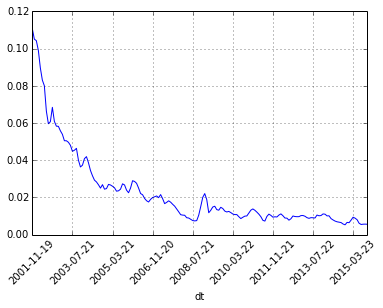

In [201]:
df.groupby('dt').mean()['proportion'].plot()
plt.xticks(rotation=45)


In [205]:
e=(pd.DataFrame([a,b,c,d]).T)
e.columns=['a','b','c','d']
e.to_excel(loc1 + 'german_stocks_adtv_20151021_2.xlsx')

In [69]:
#dfagg[[0,1,2,3,5,6,13,10,14]].to_csv(loc1 + '00_german_stocks_adtv.csv',sep=';',index=False)
df = dfagg[[0,1,2,3,4,5,6,13,10,14]]
df = df.rename(columns={'adtv':'adtv_xetra'})
df['proportion'] = df['adtv_frankfurt'] / (df['adtv_xetra'] + df['adtv_frankfurt'])
df[df['proportion']>0.20]

df.to_csv(loc1 + '00_german_stocks_adtv.csv',sep=';',index=False)

In [53]:
#adtv compare
dtto=dt.date(2014,1,19) - dt.timedelta(days=5)
dtfr=dt.date(2013,11,6) - dt.timedelta(days=6)
dfprimall=get_adtv_prim_plus(str('B0662J'), dtto, dtfr, 'EUR')
dfsecall=get_adtv_sec_plus(str('B0662J'), dtto, dtfr, 'EUR')

adtv_prim=mean(dfprimall.loc[:,'close_']*dfprimall.loc[:,'volume'])  
print(adtv_prim)
print('-')

ex=dfsecall['exch'].drop_duplicates().reset_index(drop=True)
for i in ex:
    print('exchange code -', i)
    dfsecall1=dfsecall[dfsecall.exch==i]
    adtv_sec1=mean(dfsecall1.loc[:,'close_']*dfsecall1.loc[:,'volume']) 
    print(adtv_sec1)

31425.1979805
-
exchange code - 292
104183.874138
exchange code - 285
298677.121917
exchange code - 239
1569763.72145
exchange code - 238
5042890.52598
exchange code - 234
7693478.9048
exchange code - 228
415686.103866
exchange code - 226
3937272.79547
exchange code - 179
289313.713935
exchange code - 78
22857048.7827
exchange code - 76
6012.76390189
exchange code - 70
62918.9199748
exchange code - 51
6704.30509096
exchange code - 23
12581.7207814


91420
91420


In [174]:
#link dys - old
#dfdy=pd.read_excel(loc+'iSTOXX_Europe_HDMV_DY.xlsx')
#dfdy['dt']=dfdy['dt'].apply(str)
#dfdy['dt']=dfdy['dt'].map(lambda x: x[:10])
#dfagg=pd.merge(dfagg, dfdy.iloc[:,[0,2,6]], how='left', left_on=['dt','sedol'], right_on=['dt','sedol'])

#DPS and Price from QAD
dfagg = pd.read_csv(loc1 + '02_europe600_adtvEUR.csv', sep=';')
dfagg = dfagg.iloc[:,:].reset_index(drop=True)

dpsdata=[]
pricedata=[]
dta = [[0 for x in range(6)] for x in range(len(dfagg))]
ct=0
for index, row in dfagg.iterrows(): ##########3  [-600:,:]
    dto=dt.datetime.strptime(row['dt'], '%Y-%m-%d')
    dimp=dto-dt.timedelta(days=3) #implem date
    
    if isnan(get_localdps(row['sedol'], dimp)):
        dpsdata.append(get_localdps(row['isin'], dimp))
    else:
        dpsdata.append(get_localdps(row['sedol'], dimp))
    
    if isnan(get_localclose(row['sedol'], dimp)):
        pricedata.append(get_localclose(row['isin'], dimp))
    else:
        pricedata.append(get_localclose(row['sedol'], dimp))
        
    ddata = get_wsfields_last_and_curr(row.sedol, 5101, dimp)
    if len(ddata)>0:
        dta[ct][0] = ddata.iloc[0,0]
        dta[ct][1] = str(ddata.iloc[0,1])
        dta[ct][2] = ddata.iloc[0,2]
        dextra = get_wsfields_last_and_curr(row.sedol, "5151,5152,5153,5154",  ddata.iloc[0,1])
        if len(dextra)>0:
            dta[ct][3] = dextra.iloc[0,0]
            dta[ct][4] = dextra.iloc[0,1]
            dta[ct][5] = dextra.iloc[0,2]
    
    if not (index+1) % 100:
        print(index+1)
    ct=ct+1

#dff is the WS data
dff = pd.DataFrame(dta, columns=['DPS_ws','dt_ws','curr_ws','extra_div','extra_dt','extra_curr'])
dff['extra_dt'] = dff['extra_dt'].map(lambda x: str(x)[:10])
dff['dt_ws'] = dff['dt_ws'].map(lambda x: str(x)[:10])
dff['final_DPS']=dff['DPS_ws']
dff.loc[(dff[(dff['dt_ws']==dff['extra_dt']) & (dff['curr_ws']==dff['extra_curr'])]).index,'final_DPS'] =dff.DPS_ws-dff.extra_div

dfagg.loc[len(dfagg)-len(pricedata):,'local_close']=pricedata
dfagg.loc[len(dfagg)-len(dpsdata):,'DPS']=dpsdata
dfagg['DY_gross']=dfagg['DPS']/dfagg['local_close']
dfagg['DY_net']=dfagg['DY_gross']*(1-dfagg['tax'])

dfagg=pd.concat([dfagg, dff], axis=1)

dfagg.to_csv(loc1 + '03_europe600_adtvEUR_dy_extended.csv',sep=';',index=False)
dfagg.head()

4532673


IndexError: index out of bounds

In [48]:
df=pd.read_csv(loc1 + 'istoxx_europe600_mvhd_selection_list_20151028.csv', sep=';')
df=df[[0,1,5,7]]
df.to_csv(loc1 + 'istoxx_europe600_mvhd_adtv_20151029.csv', sep=';', index=False)

In [29]:
pd.read_csv(loc1 + '02_europe600_adtvEUR.csv', sep=';').sort('dt',ascending=True)

,dt,isin,issue_curr,name,sedol,symbol,industry,dt-50,dt-125,dt-500,adtv,tax,country,isocode
1,2015-08-24,AT0000606306,EUR,RAIFFEISEN BANK INTERNATIONAL,B0704T9,B0704T,8000,2015-06-15,2015-02-26,2013-09-09,9047148.581112,0.25,Austria,AT
0,2015-08-24,AT0000652011,EUR,ERSTE GROUP BANK,5289837,528983,8000,2015-06-15,2015-02-26,2013-09-09,20781584.038780,0.25,Austria,AT


In [32]:
#final proc to get dy - final 02.09.2015
def get_localdps_table(identifier, infoc=0):
    if infoc==0:
        ic = get_infocode(identifier)
    elif infoc!=0:
        ic = infoc
        
    if np.isnan(ic):
        return pd.DataFrame(columns=['dt', 'curr', 'dps',])
    else:        
        sql = """
        SELECT a.EventDate, d.EffectiveDate, round(a.DPS, 5), b.DivRate as ext, c.PrimISOCurrCode as curr FROM DS2DPS a 
        LEFT JOIN (SELECT * FROM DS2Div DS2Div WHERE InfoCode = '%s' and DivTypeCode='EXT') b
        ON a.EventDate = b.AnnouncedDate
        LEFT JOIN (SELECT * FROM DS2Div DS2Div WHERE InfoCode = '%s' and not DivTypeCode='EXT') d
        ON a.EventDate = d.AnnouncedDate
        LEFT JOIN Ds2CtryQtInfo c on a.InfoCode = c.InfoCode
        WHERE a.InfoCode = '%s'
        ORDER BY EventDate DESC
        """ % (str(ic),str(ic),str(ic))
        res = pd.io.sql.read_sql(sql,con).values
        if len(res) > 0:
            df = pd.DataFrame(res, columns=['dt', 'exdt', 'dps_', 'ext', 'curr']).fillna(0)
            df['dps'] = df['dps_'] - df['ext']
            del df['ext']
            del df['dps_']
            return df
        else:
            return pd.DataFrame(columns=['dt', 'exdt', 'curr', 'dps',])

def get_adjpr_table(identifier, infoc=0):
    if infoc==0:
        ic = get_infocode(identifier)
    elif infoc!=0:
        ic = infoc
        
    c = get_currency(identifier)
    if np.isnan(ic):
        return pd.DataFrame(columns=['dt','close_', 'cumadj', 'adjclose'])
    else: 
        sql = """
        SELECT a.MarketDate, a.Close_, b.CumAdjFactor, a.Close_ * b.CumAdjFactor AS close_adjusted_loc
        FROM DS2PrimQtPrc a, DS2Adj b
        WHERE a.InfoCode = b.InfoCode
        AND a.MarketDate between b.AdjDate and isnull(b.EndAdjdate, '20790101')
        AND b.AdjType = 2
        AND a.InfoCode = '%s'      
        order by a.MarketDate desc
        """ % (str(ic))
        res = pd.io.sql.read_sql(sql,con).values
        if len(res) > 0:
            df = pd.DataFrame(res, columns=['dt','close_', 'cumadj', 'adjclose'])
            df['dt'] = df['dt'].map(lambda x: str(x)[:10])
            df['dt'] = pd.to_datetime(df['dt'], format='%Y-%m-%d', dayfirst=True)
            
            if c == 'GBP':
                df[['close_', 'adjclose']]  = df[['close_', 'adjclose']] / 100
            return df
        else:
            return pd.DataFrame(columns=['dt','close_', 'cumadj', 'adjclose'])
        
#DPS and Price from QAD - new proc
dfagg = pd.read_csv(loc1 + '02_europe600_adtvEUR.csv', sep=';').sort('dt',ascending=True)
dfagg = dfagg[dfagg.sedol=='3034545']
dfagg = dfagg[(dfagg.dt>'2007-01-01') & (dfagg.dt<'2007-02-01')]

#get the dates table
dfdtt = dfagg['dt'].drop_duplicates().reset_index(drop=True)
dfdt = pd.concat([dfdtt, pd.DataFrame(dfdtt).set_index([list(dfdtt.index+1)])[:-1], pd.DataFrame(dfdtt).set_index([list(dfdtt.index+12)])[:-12]], axis=1)
dfdt.columns = [0,1,2]
addts = ['2001-11-19','2001-10-22']
#dfdt = pd.concat([pd.DataFrame.transpose(pd.DataFrame(addts)),dfdt], axis=0).reset_index(drop=True)
dfdt.columns = ['dt','dt-1','dt-12']
dfdt.loc[0,'dt-1'] = '2001-10-22'
#dfdt.loc[:11,'dt-12'] = ['2000-11-20','2000-12-18','2001-01-22','2001-02-19',
#                         '2001-03-19','2001-04-23','2001-05-21','2001-06-18',
#                         '2001-07-23','2001-08-20','2001-09-24','2001-10-22']
dfdt = dfdt.apply(lambda x: pd.to_datetime(x, format='%Y-%m-%d', dayfirst=True))
del dfdt['dt-1']

#dfagg['dt'] = pd.to_datetime(dfagg['dt'], format='%Y-%m-%d', dayfirst=True)
#dfagg = dfagg.loc[-20:, dfagg.columns].reset_index(drop=True) ####filter here
dfagg = dfagg.iloc[:,:].reset_index(drop=True)
dfagg = dfagg.reset_index(drop=True)
#dfagg = dfagg[dfagg.symbol.isin(['B03851'])]  ###########################################


ct = 0
#dta = [[0 for x in range(9)] for x in range(len(dfagg))]
dta = []
dfdta = pd.DataFrame()
dfids = dfagg[['symbol','sedol','isin']].drop_duplicates().reset_index(drop=True)
for index, row in dfids.iterrows():
            
    if isnan(get_infocode(row.sedol)):
        dfa = get_localdps_table(dfids.loc[index,'isin']) #dps
        df1a = get_adjpr_table((dfids.loc[index,'isin'])) #price
        infocode = get_infocode(dfids.loc[index,'isin'])
    else:
        dfa = get_localdps_table(row.sedol)
        df1a = get_adjpr_table(row.sedol)
        infocode = get_infocode(row.sedol)
        if row.symbol=='B03851':
            dfb = get_localdps_table(row.sedol, 248357)
            df1b = get_adjpr_table(row.sedol, 248357)            
            
    #get pricing table
    
    dfrow = dfagg[(dfagg.sedol==row.sedol) & (dfagg['isin']==dfids.loc[index,'isin'])].reset_index(drop=True)
    for s in range(len(dfrow)):
               
        dto=dt.datetime.strptime(dfrow.loc[s, 'dt'], '%Y-%m-%d')
        dfdtall = dfdt[dfdt.dt==dto].reset_index(drop=True)
        #dimp=dto-dt.timedelta(days=3) #implem date
        dc = 0
        dftemp = pd.DataFrame()
        for d in list(dfdtall.iloc[0]):
            if (row.symbol=='B03851') & (dfrow.loc[s, 'dt']<'2009-12-04'):
                print('here')
                df=dfb
                df1=df1b
            else:
                df=dfa
                df1=df1a                
            
            #print(d,s,dfrow.loc[s, 'dt'], dc)
            d = d-dt.timedelta(days=5)
            if len(df[(df.dt<d) & (df.dt>=add_months(d,-18)) & (-df.dps.isnull())])>0:
                dpsdt = df[(df.dt<d) & (df.dt>=add_months(d,-18)) & (-df.dps.isnull())].iloc[0,0] #date of last dps
                curr = df[(df.dt<d) & (df.dt>=add_months(d,-18)) & (-df.dps.isnull())].iloc[0,2] #curr
                dps1 = float(df[(df.dt<d) & (df.dt>=add_months(d,-18)) & (-df.dps.isnull())].iloc[0,3]) #last dps
            else:
                dpsdt = np.nan
                exdt = np.nan
                curr = np.nan
                dps1 = np.nan

            if len(df1[(df1.dt<d) & (-df1.close_.isnull())])>0:
                pr = np.round(float(df1[(df1.dt<d) & (-df1.close_.isnull())].iloc[0,1]), 6)
                try:
                    adjfact = np.round(float(df1[(df1.dt<=dpsdt) & (-df1.close_.isnull())].iloc[0,2]) / float(df1[(df1.dt<=d) & (-df1.close_.isnull())].iloc[0,2]),6)
                    #dtdelta = (d-dt.datetime.strptime(str(dpsdt)[:10], '%Y-%m-%d')).days
                except:
                    adjfact = 1
            else:
                pr = np.nan
                adjfact = np.nan
            if dc==0:
                dpsdt0 = dpsdt
            elif dc==1:
                dpsdt12 = dpsdt
                dps12 = dps1 * adjfact
            
            dps = np.round(dps1 * adjfact, 3)
            strdc = str(dc)
            dfthisdate = pd.DataFrame(np.array([pr, adjfact, dps])).transpose()
            dfthisdate.columns=['pr_'+strdc,'adjfact_'+strdc, 'dps_'+strdc]
            dftemp = pd.concat([dftemp, dfthisdate], axis=1)
            dc = dc + 1
        try:    
            adjfact12m = np.round(float(df1[(df1.dt<=dpsdt12) & (-df1.close_.isnull())].iloc[0,2]) / float(df1[(df1.dt<=dpsdt0) & (-df1.close_.isnull())].iloc[0,2]),6) 
        except:
            adjfact12m = 1
        dfdpsadj = pd.DataFrame(np.array([adjfact12m, np.round(dps12 * adjfact12m, 3)])).transpose()
        dfdpsadj.columns=['adjfact_12m', 'dps_1adj']
        dftemp = pd.concat([dftemp, dfdpsadj], axis=1)
        
        dfref = pd.DataFrame(np.array([dfrow.loc[s, 'dt'],
                         dfrow.loc[s, 'sedol'],
                         dfrow.loc[s,'isin'],
                         infocode])).transpose()
        dfref.columns = ['dt','sedol','isin','infocode']
        
        dfdta1 = pd.concat([dfref, dftemp], axis=1)
        dfdta = pd.concat([dfdta, dfdta1], axis=0)
            
        ct = ct+1
           
        if not (ct+1) % 1000:
            print(ct+1)
            
#dfdta = pd.DataFrame(dta, columns=['dt','sedol','isin','infocode','price','dps_','dps_date','exdate', 'deltadays','dps_curr','adjfact'])
dfres = pd.merge(dfagg, dfdta, how='left', on=['dt', 'sedol','isin']).drop_duplicates()
dfres = dfres.rename(columns={'adtv':'adtvEUR', 'adtv_prev':'adtvEUR_prev'}) #to change, no more adtv_prev

#dfres['price'] = dfres['price'].map(float)
#dfres['dps_'] = dfres['dps_'].map(float)
#dfres['adjfact'] = dfres['adjfact'].map(float)

dfres.loc[dfres[(dfres.sedol=='4253048') & (dfres.dt>='2015-02-25')].index, 'dps_0'] = 300.
#dfres.loc[dfres[(dfres.sedol=='4253048') & (dfres.dt>='2015-03-25')].index, 'dps_1'] = 300.
dfres.loc[dfres[(dfres.sedol=='B0LKSK4') & (dfres.dt>='2012-02-19') & (dfres.dt<='2012-08-20')].index, 'dps_0'] = 1.
#dfres.loc[dfres[(dfres.sedol=='B0LKSK4') & (dfres.dt>='2012-03-19') & (dfres.dt<='2012-09-20')].index, 'dps_1'] = 1.
dfres.loc[dfres[dfres.sedol=='0987794'].index, ['pr_0', 'pr_1']] = dfres[['pr_0', 'pr_1']] * 100.
dfres.loc[dfres[(dfres.sedol=='0504502') & (dfres.dt>='2001-11-19') & (dfres.dt<='2002-08-19')].index, ['pr_0', 'pr_1']] = dfres[['pr_0', 'pr_1']] * 100.

#dfres['dps'] = dfres['dps_'] * dfres['adjfact']
dfres.loc[dfres[dfres.isocode=='BE'].index,['dps_0','dps_1']] = dfres[['dps_0','dps_1']] / 0.75
dfres['dy_0'] = dfres['dps_0'] / dfres['pr_0']
dfres['dy_1'] = dfres['dps_1'] / dfres['pr_1']
#dfres['dy_2'] = dfres['dps_2'] / dfres['pr_2']

#dfres.to_csv(loc1 + '03_europe600_adtvEUR_dy_ferrovial.csv',sep=';',index=False)
#dfres[[0,1,2,3,4,5,9,10,13,14,15,17,18,20,21,23,25,26,27,28]].to_csv(loc1 + '03_europe600_adtvEUR_dy.csv',sep=';',index=False)
print('done')
dfres

KeyError: 'dt'

In [39]:
dfagg = pd.read_csv(loc1 + '02_europe600_adtvEUR.csv', sep=';').sort('dt',ascending=True)
dfagg = dfagg[dfagg['isin']=='GB0030345457']
#dfagg = dfagg[(dfagg.dt>'2007-01-01') & (dfagg.dt<'2007-02-01')]
dfagg.tail()

,dt,isin,issue_curr,name,sedol,symbol,industry,dt-50,dt-125,dt-500,adtv,tax,country,isocode
22397,2004-12-20,GB0030345457,GBP,WHITBREAD,3034545,096050,5000.0,2004-10-11,2004-06-28,2003-01-09,28981914.736713,0,Great Britain,GB
22997,2005-01-24,GB0030345457,GBP,WHITBREAD,3034545,096050,5000.0,2004-11-15,2004-08-02,2003-02-13,25319803.439956,0,Great Britain,GB
23597,2005-02-21,GB0030345457,GBP,WHITBREAD,3034545,096050,5000.0,2004-12-13,2004-08-30,2003-03-13,23301928.997596,0,Great Britain,GB
24200,2005-03-21,GB0030345457,GBP,WHITBREAD,3034545,096050,5000.0,2005-01-10,2004-09-27,2003-04-10,29776020.644961,0,Great Britain,GB
24800,2005-04-18,GB0030345457,GBP,WHITBREAD,3034545,096050,5000.0,2005-02-03,2004-10-21,2003-05-08,28862028.426600,0,Great Britain,GB


In [254]:
df[df.dt<'2009-12-15'].head(10)
dfr=pd.concat([df[df.dt>'2009-12-03'],dfx], axis=0).reset_index(drop=True)
#dfr[dfr.dt<'2009-12-15'].head(10)
dfr

,dt,exdt,curr,dps
0,2015-05-06,0,EUR,0.67478
1,2015-04-30,0,EUR,0.68500
2,2014-11-04,0,EUR,0.66442
3,2014-07-02,0,EUR,0.68062
4,2014-06-16,0,EUR,0.69300
5,2013-10-28,2013-12-10 00:00:00,EUR,0.65000
6,2013-02-19,0,EUR,1.25000
7,2012-11-29,2012-12-13 00:00:00,EUR,0.25000
8,2012-11-29,2013-05-23 00:00:00,EUR,0.25000
9,2012-02-23,2012-05-24 00:00:00,EUR,0.45000


In [9]:
#all data
dfagg = pd.read_csv(loc1 + '03_europe600_adtvEUR_dy.csv', sep=';')
dfagg.reset_index(inplace=True,drop=True)
#dfagg = dfagg[dfagg.dt.isin(['2010-01-18','2011-01-24','2015-04-20'])]
dfout = dfagg[[0,1,2,3,5,6,10,13,14,15,17,18,20,22,23,24]]
dfout.to_csv(loc1 + 'stoxx_europe600_data_20151221.csv',sep=';',index=False)
dfout.head(2)
#dfout.iloc[:33800,:].to_csv(loc1 + 'stoxx_europe600_data_20151221_1.csv',sep=';',index=False)
#dfout.iloc[33800:67600,:].to_csv(loc1 + 'stoxx_europe600_data_20151221_2.csv',sep=';',index=False)
#dfout.iloc[67600:,:].to_csv(loc1 + 'stoxx_europe600_data_20151221_3.csv',sep=';',index=False)

,dt,isin,issue_curr,name,sedol,symbol,industry,adtvEUR,isocode,infocode,pr_0,dps_0,pr_1,dps_1,dps_1adj,dy_0,dy_1
0,2001-11-19,US87162M1027,CHF,SYNTHES STRATEC,4532673,566148,HCR,5279540.025213,CH,39393,1137.0,6.00,1079,3,3,0.005277,0.00278
1,2001-11-19,SE0000718017,SEK,ENIRO,4466802,446680,IDU,5696238.484097,SE,10649,71.5,0.65,95,0,0,0.009091,0.00000


In [96]:
df5 = pd.read_csv(loc1 +'istoxx_europe600_mvhd_selection_list_20160108.csv', sep=';')
x = df5[df5.new==True].groupby('dt').count()['symbol']

In [99]:
df5 = pd.read_csv(loc1 +'istoxx_europe600_mvhd_selection_list_20151104.csv', sep=';')
y = df5[df5.new==True].groupby('dt').count()['symbol']

dt
2001-11-19    73
2001-12-24    79
2002-01-21    78
2002-02-18    79
2002-03-18    80
2002-04-22    79
2002-05-20    83
2002-06-24    84
2002-07-22    86
2002-08-19    84
2002-09-23    80
2002-10-21    72
2002-11-18    77
2002-12-23    79
2003-01-20    75
2003-02-24    76
2003-03-24    74
2003-04-22    71
2003-05-19    78
2003-06-23    78
2003-07-21    77
2003-08-18    73
2003-09-22    76
2003-10-20    77
2003-11-24    82
2003-12-22    79
2004-01-19    78
2004-02-23    83
2004-03-22    87
2004-04-19    92
              ..
2013-05-20    90
2013-06-24    91
2013-07-22    90
2013-08-19    89
2013-09-23    89
2013-10-21    88
2013-11-18    86
2013-12-23    87
2014-01-20    91
2014-02-24    99
2014-03-24    97
2014-04-22    96
2014-05-19    89
2014-06-23    90
2014-07-21    89
2014-08-18    90
2014-09-22    90
2014-10-20    87
2014-11-24    88
2014-12-22    90
2015-01-19    87
2015-02-23    90
2015-03-23    89
2015-04-20    87
2015-05-18    90
2015-06-22    90
2015-07-20    87
2015-08-24 

In [72]:
df5 = pd.read_csv(loc1 +'03_europe600_adtvEUR_dy_.csv', sep=';')
df5.groupby('dt').count()['symbol']

dfc = pd.read_csv(loc1 +'03_europe600_adtvEUR_dy_2.csv', sep=';').drop_duplicates()
dfc.groupby('dt').count()['infocode']
len(dfc)

101407

In [67]:
dfc = pd.read_csv(loc1 +'02_europe600_adtvEUR.csv', sep=';')
dfdta = pd.read_csv(loc1 + '01_dfdta_.csv', sep=';')
#print(dfc.head(2))
#print('----')
#print(dfdta.head(2))

df1 = pd.merge(dfc, dfdta, how='left', on=['dt','infocode'])
#df1.to_csv(loc1 + '00_try_error.csv', sep=';', index=False)
print(len(dfc), len(dfdta), len(df1))

df1.groupby('dt').count()

#dfids = dfc[-dfc.infocode.isnull()]['infocode'].drop_duplicates().reset_index(drop=True)

#dfids[dfids.isnull()]


101407 101406 101425


,isin,issue_curr,name,sedol,symbol,industry,dt-50,dt-125,dt-500,adtv,...,isocode,infocode,pr_0,adjfact_0,dps_0,pr_1,adjfact_1,dps_1,adjfact_12m,dps_1adj
dt,,,,,,,,,,,,,,,,,,,,,
2001-11-19,600,600,600,600,600,600,600,600,600,600,...,600,600,600,600,580,581,581,574,600,574
2001-12-24,600,600,600,600,600,600,600,600,600,600,...,600,600,598,598,576,587,587,579,600,579
2002-01-21,600,600,600,600,600,600,600,600,600,600,...,600,600,598,598,574,586,586,576,600,576
2002-02-18,600,600,600,600,600,600,600,600,600,600,...,600,600,598,598,573,589,589,577,600,577
2002-03-18,600,600,600,600,600,600,600,600,600,600,...,600,600,599,599,576,587,587,575,600,575
2002-04-22,600,600,600,600,600,600,600,600,600,600,...,600,600,599,599,579,588,588,576,600,576
2002-05-20,600,600,600,600,600,600,600,600,600,600,...,600,600,599,599,581,587,587,576,600,576
2002-06-24,600,600,600,600,600,600,600,600,600,600,...,600,600,598,598,578,585,585,573,600,573
2002-07-22,600,600,600,600,600,600,600,600,600,600,...,600,600,599,599,580,588,588,576,600,576


In [23]:
dfagg = pd.read_csv(loc1 + '03_europe600_adtvEUR_dy.csv', sep=';').iloc[:,:] #01_europe600_data 03_europe600_adtvEUR_dy
#dfagg.head(2)
print(len(dfagg))
dfagg.groupby('dt').count()['symbol']

103207


dt
2001-11-19    600
2001-12-24    600
2002-01-21    600
2002-02-18    600
2002-03-18    600
2002-04-22    600
2002-05-20    600
2002-06-24    600
2002-07-22    600
2002-08-19    600
2002-09-23    600
2002-10-21    600
2002-11-18    600
2002-12-23    600
2003-01-20    600
2003-02-24    600
2003-03-24    600
2003-04-22    600
2003-05-19    600
2003-06-23    600
2003-07-21    600
2003-08-18    600
2003-09-22    600
2003-10-20    600
2003-11-24    600
2003-12-22    600
2004-01-19    600
2004-02-23    600
2004-03-22    600
2004-04-19    600
             ... 
2013-09-23    600
2013-10-21    600
2013-11-18    600
2013-12-23    600
2014-01-20    600
2014-02-24    601
2014-03-24    600
2014-04-22    600
2014-05-19    600
2014-06-23    600
2014-07-21    600
2014-08-18    600
2014-09-22    600
2014-10-20    600
2014-11-24    600
2014-12-22    601
2015-01-19    601
2015-02-23    600
2015-03-23    600
2015-04-20    600
2015-05-18    601
2015-06-22    600
2015-07-20    600
2015-08-24    600
2015-09

In [2]:
#new selection 20150827 - current
dfagg = pd.read_csv(loc1 + '03_europe600_adtvEUR_dy.csv', sep=';').iloc[:,:] #8400
dfagg = dfagg[[0,1,2,3,4,5,6,7,8,9,10,13,14,17,22,23,24]]

#adtv ranks
#rankadtv = dfagg[dfagg.adtv!=0].groupby('dt')['adtvEUR'].rank(method='first', ascending=0) 
dfagg['rankadtv']=dfagg[dfagg.adtv!=0].groupby('dt')['adtv'].rank(method='first', ascending=0) #to check ranks

dfagg['rankadtv_prev'] = np.nan

#get prev adtvrank
ct = 0
for d in dfagg.sort('dt', ascending=True)['dt'].drop_duplicates():
    if ct>0:
        #mark the current components
        dfnew = dfagg[dfagg.dt==d][['symbol']].reset_index(drop=True) #take all current candidates
        dfnew = pd.merge(dfnew, dfold, how='left', on='symbol')
        listold = dfnew['rankadtv'].tolist()
        dfagg.loc[dfagg[dfagg.dt==d].index,'rankadtv_prev'] = listold
        
    dfold = dfagg[(dfagg.dt==d) & (dfagg.adtv!=0)][['symbol','rankadtv']].reset_index(drop=True)
    ct=ct+1
    
idxtokeep1 = dfagg[dfagg.rankadtv<=300].index
idxtokeep2 = dfagg[(dfagg.rankadtv>300) & (dfagg.rankadtv<=350) & (dfagg.rankadtv_prev<=300)].index

dfagg['adtv_rule'] = ''
dfagg.loc[idxtokeep1, 'adtv_rule'] = 'PASS'
dfagg.loc[idxtokeep2, 'adtv_rule'] = 'PASS'

#dlc rule
dfagg['dlc_rule'] = ''
for d in dfagg.sort('dt', ascending=True)['dt'].drop_duplicates():
    #adjustments for dual listings
    icodes = [[45981,74732],[45961,46201],[45990,48759],[46770,46952]]  #shell, unilever, reed, fortis
    for c in range(len(icodes)):
        dfdl = dfagg[(dfagg.dt==d) & (dfagg.infocode.isin(icodes[c]))]
        if len(dfdl)>1:
            idxmin = dfdl[dfdl.dy_0==dfdl['dy_0'].min()].index
            idxmax = dfdl[dfdl.dy_0==dfdl['dy_0'].max()].index
            dfagg.loc[idxmin, 'dlc_rule'] = 'FAIL'
            dfagg.loc[idxmax, 'dlc_rule'] = 'PASS'

##dy ranks
dfagg['rankdy0']=dfagg[(dfagg.adtv_rule=='PASS') & (dfagg.dlc_rule!='FAIL')].groupby('dt')['dy_0'].rank(method='first', ascending=0)
dfagg['rankdy_prev'] = np.nan
dfagg['rankdy1']=dfagg[(dfagg.adtv_rule=='PASS') & (dfagg.dlc_rule!='FAIL')].groupby('dt')['dy_1'].rank(method='first', ascending=0)

#get prev dy rank
ct=0
for d in dfagg.sort('dt', ascending=True)['dt'].drop_duplicates():
    if ct>0:
        #mark the current components
        dfnew = dfagg[dfagg.dt==d][['symbol']].reset_index(drop=True) #take all current candidates
        dfnew = pd.merge(dfnew, dfold, how='left', on='symbol')
        listold = dfnew['rankdy0'].tolist()
        dfagg.loc[dfagg[dfagg.dt==d].index,'rankdy_prev'] = listold
        
    dfold = dfagg[(dfagg.dt==d) & (dfagg.adtv_rule=='PASS')][['symbol','rankdy0']].reset_index(drop=True)
    ct=ct+1

idxtokeep3 = dfagg[(dfagg.rankdy0<=100) & (dfagg.rankdy1<=200)].index
idxtokeep4 = dfagg[(dfagg.rankdy0>100) & (dfagg.rankdy0<=150) & (dfagg.rankdy_prev<=100) & (dfagg.rankdy1<=200)].index

dfagg['dy_rule'] = ''
dfagg.loc[idxtokeep3, 'dy_rule'] = 'PASS'
dfagg.loc[idxtokeep4, 'dy_rule'] = 'PASS'

#rule for non components
dfagg['dps_rule'] = ''
dfagg['old'] = False
dfagg['new'] = ''
ct=0
for d in dfagg.sort('dt', ascending=True)['dt'].drop_duplicates():
    if ct==0:
        dfagg.loc[dfagg[(dfagg.dt==d) & (dfagg.dy_rule=='PASS')].index,'old'] = False
    else:
        #mark the current components
        dfnew = dfagg[(dfagg.dt==d) & (dfagg.dy_rule=='PASS')][['symbol']] #take all current candidates
        dfnew = pd.merge(dfnew, dfold, how='left', on='symbol') #link old (column new)
        dfnew['new'] = dfnew['new'].fillna(False)
        listold = dfnew['new'].tolist()
        dfagg.loc[dfagg[(dfagg.dt==d) & (dfagg.dy_rule=='PASS')].index,'old'] = listold
        
    idxtodel = dfagg[(dfagg.dt==d) & -(dfagg.old==True) & (dfagg.dy_rule=='PASS') & (dfagg.dps_1adj>=dfagg.dps_0)].index
    #dfagg = dfagg[-dfagg.index.isin(index2del)]
    dfagg.loc[dfagg[(dfagg.dt==d) & (dfagg.dy_rule=='PASS')].index,'new'] = True #first set all to true
    dfagg.loc[idxtodel,'new'] = False
    dfold = dfagg[dfagg.dt==d][['symbol','new']]
    
    ct=ct+1
    
dfagg.loc[dfagg[(dfagg.old!=True) & (dfagg.new==False)].index, 'dps_rule'] = 'FAIL'
dfagg.loc[dfagg[(dfagg.old!=True) & (dfagg.new==True)].index, 'dps_rule'] = 'PASS'
dfagg.loc[dfagg[(dfagg.old==True) & (dfagg.new==True)].index, 'dps_rule'] = 'NOT APPLICABLE'
#dfagg.loc[dfagg[dfagg.dlc_rule=='FAIL'].index, 'new'] = ''
dfagg.loc[dfagg[dfagg.new==False].index, 'new'] = ''

dfagg[dfagg.new==True].to_csv(loc1 + '04_europe600_mvhd_selection.csv', sep=';', index=False)
dfagg.to_csv(loc1 + '04_europe600_mvhd_selection_list.csv', sep=';', index=False)

dfagg= dfagg[[0,1,2,3,4,5,6,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27]]
dfagg[dfagg.new==True].to_csv(loc1 + 'istoxx_europe600_mvhd_selection_20160229.csv', sep=';', index=False)
dfagg.to_csv(loc1 + 'istoxx_europe600_mvhd_selection_list_20160229.csv', sep=';', index=False)
#dfagg.iloc[dfagg[(dfagg.dt>'2011-06-01') & (dfagg.dt<'2012-01-01')].index,:].to_csv(loc1 + 'istoxx_europe600_mvhd_selection_list_sample_20151008.csv', sep=';', index=False)
dfagg[dfagg.new==True].groupby('dt').count('isin')['isin']

C:\Users\txg2a\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas-0.16.0-py3.4-win-amd64.egg\pandas\io\parsers.py:1164: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


dt
2001-11-19    73
2001-12-24    78
2002-01-21    79
2002-02-18    78
2002-03-18    79
2002-04-22    79
2002-05-20    83
2002-06-24    81
2002-07-22    84
2002-08-19    86
2002-09-23    82
2002-10-21    79
2002-11-18    76
2002-12-23    76
2003-01-20    76
2003-02-24    78
2003-03-24    75
2003-04-22    73
2003-05-19    80
2003-06-23    79
2003-07-21    79
2003-08-18    78
2003-09-22    80
2003-10-20    79
2003-11-24    82
2003-12-22    81
2004-01-19    78
2004-02-23    83
2004-03-22    87
2004-04-19    90
              ..
2013-09-23    89
2013-10-21    88
2013-11-18    86
2013-12-23    90
2014-01-20    89
2014-02-24    96
2014-03-24    96
2014-04-22    96
2014-05-19    92
2014-06-23    93
2014-07-21    90
2014-08-18    90
2014-09-22    88
2014-10-20    86
2014-11-24    88
2014-12-22    88
2015-01-19    87
2015-02-23    89
2015-03-23    91
2015-04-20    88
2015-05-18    91
2015-06-22    90
2015-07-20    88
2015-08-24    89
2015-09-21    88
2015-10-19    89
2015-11-23    90
2015-12-21 

In [3]:
#all data - selection list
dfagg = pd.read_csv(loc1 + 'istoxx_europe600_mvhd_selection_list_20160229.csv', sep=';')
len(dfagg)
dfagg = dfagg[[0,1,2,3,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]]
dfagg.iloc[:25000,:].to_csv(loc1 + 'istoxx_europe600_mvhd_selection_list_20160229_1.csv',sep=';',index=False)
dfagg.iloc[25000:50000,:].to_csv(loc1 + 'istoxx_europe600_mvhd_selection_list_20160229_2.csv',sep=';',index=False)
dfagg.iloc[50000:75000,:].to_csv(loc1 + 'istoxx_europe600_mvhd_selection_list_20160229_3.csv',sep=';',index=False)
dfagg.iloc[75000:,:].to_csv(loc1 + 'istoxx_europe600_mvhd_selection_list_20160229_4.csv',sep=';',index=False)

In [50]:
dfagg[(dfagg.dt=='2016-01-18') | (dfagg.dt=='2016-02-22')].to_csv(loc1 + 'istoxx_europe600_mvhd_selection_list_2016.csv',sep=';',index=False)

1200

In [4]:
#code to update the missing data due to mapping issues

#df = pd.read_csv(loc1 + '03_europe600_adtvEUR_dy_dscodes.csv', sep=';').sort('dt',ascending=True)
#df= df[[0,1,2,3,5,6,10,13,15,18,23,24,25]]
#df.to_csv(loc1 + 'isemvhd_missing_data_20151104.csv', sep=';', index=False)
df1 = pd.read_csv(loc1 + '03_europe600_adtvEUR_dy.csv', sep=';').sort('dt',ascending=True)
df2 = pd.read_csv(loc1 + '03_europe600_adtvEUR_dy_dscodes.csv', sep=';').sort('dt',ascending=True)
del df2['dscode']
#dtype={'infocode': float64, 'symbol': object},
#df2 = df2[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,15,16,17,18,19,20,21,22,23,24,25]]

#df2=df2[]
print(len(df2))
for index, rows in  df2.iterrows():
    x=df1[(df1.dt==rows['dt']) & (df1.sedol==rows.sedol)].index
    for r in list([10,14,15,16,17,18,19,20,21,22,23,24]):
        df1.loc[x, df1.columns[r]] = rows[r]

    if not (index+1) % 2000:
        print(index+1)
        
df1.to_csv(loc1 + '03_europe600_adtvEUR_dy1.csv',sep=';',index=False)
print('done')

93809
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000
20500
21000
21500
22000
22500
23000
23500
24000
24500
25000
25500
26000
26500
27000
27500
28000
28500
29000
29500
30000
30500
31000
31500
32000
32500
33000
33500
34000
34500
35000
35500
36000
36500
37000
37500
38000
38500
39000
39500
40000
40500
41000
41500
42000
42500
43000
43500
44000
44500
45000
45500
46000
46500
47000
47500
48000
48500
49000
49500
50000
50500
51000
51500
52000
52500
53000
53500
54000
54500
55000
55500
56000
56500
57000
57500
58000
58500
59000
59500
60000
60500
61000
61500
62000
62500
63000
63500
64000
64500
65000
65500
66000
66500
67000
67500
68000
68500
69000
69500
70000
70500
71000
71500
72000
72500
73000
73500
74000
74500
75000
75500
76000
76500
77000
77500
78000
78500
79000
79500
80000
80500
81000
81500
82000
82500
83000
83500
84000
84500


In [7]:
df1 = pd.read_csv(loc1 + 'istoxx_europe600_mvhd_selection_list_sample_20151008.csv', sep=';')
a= df1[df1.new==True].groupby('dt').count('isin')['isin']
df2 = pd.read_csv(loc1 + '04_europe600_mvhd_selection.csv', sep=';')
b= df2.groupby('dt').count('isin')['isin']
z= pd.concat([a, b], axis=1)
z.columns = ['a', 'b']
z['dif']=z['a'] - z['b']
z.max()

a       87
b      105
dif      0
dtype: float64

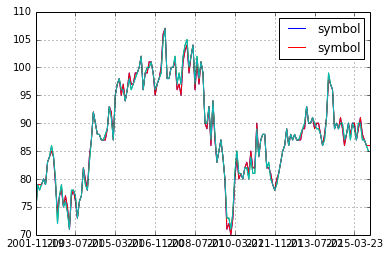

In [7]:
a1 = pd.read_csv(loc1 + '04_europe600_mvhd_selection.csv', sep=';')
x=a1.groupby('dt').count()['symbol']
a2 = pd.read_csv(loc1 + '04_europe600_mvhd_selection_.csv', sep=';')
y=a2.groupby('dt').count()['symbol']
pd.concat([x,y],axis=1).plot()

14591
done


In [79]:
dfeaster

,Date,easter
0,2000-04-21,fr
1,2000-04-24,mo
2,2001-04-13,fr
3,2001-04-16,mo
4,2002-03-29,fr
5,2002-04-01,mo
6,2003-04-18,fr
7,2003-04-21,mo
8,2004-04-09,fr
9,2004-04-12,mo


In [73]:
#time series
dfagg = pd.read_csv(loc1 + '04_europe600_mvhd_selection.csv', sep=';')
dfeaster = pd.read_csv(loc + 'easter_dates.txt', sep=';') #get easter date list
dfeaster.columns = ['Date','easter']
#dfeaster['dt'] = pd.to_datetime(dfif['Date'], format='%Y-%m-%d', dayfirst=True)

#dfagg=dfagg.iloc[-50:,:13] #391
#dfagg['dt125']=dfagg['dt-125'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

dfmap = dfagg
dfmap['seq'] = ''
#getting prices
print (len(dfagg))
ct=0
for d in sorted(dfagg.dt.drop_duplicates()):
    ct=ct+1
    print(ct,' -- ', d)
    if ct==1:
        a=[str(i) for i in list(dfagg[dfagg['dt']==d]['sedol'])]
        b=[str(i) for i in list(dfagg[dfagg['dt']==d]['isin'])]
        c=[str(i) for i in list(dfagg[dfagg['dt']==d]['infocode'])]
        #dfrom1=dt.datetime.strptime(dfagg[dfagg['dt']==d].reset_index(drop=True).loc[0,'dt-125'], '%Y-%m-%d') #dt-125
        dfrom2=dt.datetime.strptime((dfagg[dfagg['dt']==d].reset_index(drop=True)).loc[0,'dt-500'], '%Y-%m-%d') #dt-500
        dto=dt.datetime.strptime(d, '%Y-%m-%d')-dt.timedelta(days=6)
        dfts=get_timeseries_total_return4(c, add_months(dfrom2,-1), dto, 'EUR')
        #dfts=get_timeseries_total_return3(a, b, add_months(dfrom2,-1), dto, 'EUR')
        #dfts1=get_timeseries_adj_close3(a, b, add_months(dfrom2,-1), dto, 'EUR')
        dfts.columns=b

        #drop if less than 90% of observations
        #cols1 = dfts.columns[dfts[dfts.index>=dfrom2].count()<(max(dfts[dfts.index>=dfrom2].count())*0.90)] #less that 90% obs for corr
        #cols2 = dfts.columns[dfts[dfts.index>=dfrom1].count()<(max(dfts[dfts.index>=dfrom1].count())*0.90)] #less that 90% obs for vola
        #cols1 = dfts.columns[dfts[-501:].count()<(max(dfts[-501:].count())*0.90)] #less that 90% obs for corr
        #cols2 = dfts.columns[dfts[-126:].count()<(max(dfts[-126:].count())*0.90)] #less that 90% obs for vola
        #dfts.drop(cols1+cols2, axis=1, inplace=True)

        dfts['dt']=dfts.index
        dfts = dfts[-((dfts.index.month==12) & ((dfts.index.day==25) + (dfts.index.day==26)))]
        dfts = dfts[-((dfts.index.month==1) & (dfts.index.day==1))]
        dfts = dfts[-dfts.index.isin(list(dfeaster.Date))]
        
        cols=dfts.columns.tolist()
        dfts=dfts[cols[-1:] + cols[:-1]] 
        dfagg[dfagg['dt']==d][[0,1,3,4,6,11,12]].to_excel(loc1 + '/files/temp/europe600_mvhd_selection_'+ str(ct) +'.xlsx', index=False)
        dfts.to_excel(loc1 + '/files/temp/europe600_mvhd_pricing_'+ str(ct) +'.xlsx', index=False)
        
        
    dfmap.loc[dfagg[dfagg.dt==d].index, 'seq'] = ct
    break
    
##dfts.head()
#dfmap.to_csv(loc1 + '05_europe600_mvhd_selection_map.csv',sep=';',index=False)
print('done')

14869
1  --  2001-11-19
done


In [69]:
int(float(c[0]))

40224

In [4]:
#get back the weights
frev = loc1 + 'results/'

dfmap = pd.read_csv(loc1 + '05_europe600_mvhd_selection_map.csv',sep=';')
dfmap = dfmap.iloc[:,:]
dfwgts = pd.DataFrame()
for s in sorted(dfmap.seq.drop_duplicates()):
    dfile = pd.read_csv(frev + 'europe600_mvhd_' + str(s) + '_output.txt', sep='\t')
    cols = dfile.columns.map(lambda x: x.strip())
    dfile.columns = cols
    dfile['seq'] = s
    dfile['wr'] = np.round(dfile['weight'], decimals=6)
    dfile = dfile[dfile['wr']!=0]
    del dfile['wr']
    dfwgts = pd.concat([dfwgts, dfile], axis=0)

##add equal weight weights - skipped as it's calculated in the IF files proc
dfmap = pd.merge(dfmap, dfwgts, how='left', on=['isin','seq'])
#dfmap['weight_eq'] = 0
#ccount = dfmap.groupby('dt').count()['isin']
#for i in range(len(ccount)):
#    dfmap.loc[dfmap[dfmap.dt==ccount.index[i]].index,'weight_eq'] = np.around(1./ ccount[i], 8)

#dfmap = dfmap[-dfmap.weight.isnull()]
dfmap[[0,1,2,3,4,5,6,11,12,28,29]].to_csv(loc1 + '06_europe600_mvhd_selection_map_wgt.csv',sep=';',index=False)
dfmap[[0,1,3,5,6,11,29]].to_csv(loc1 + 'ismvhd_final_weights_20160229.csv',sep=';',index=False)
#dfmap.groupby('dt').count()['isin']
print('done')
dfmap.head(3)

done


,dt,isin,issue_curr,name,sedol,symbol,industry,dt-50,dt-cut,dt-500,...,dlc_rule,rankdy0,rankdy_prev,rankdy1,dy_rule,dps_rule,old,new,seq,weight
0,2001-11-19,SE0000667891,SEK,SANDVIK,5963108,477472,IDU,2001-09-05,2001-11-13,1999-12-10,...,NaN,54,NaN,36,PASS,PASS,False,True,1,0.006662
1,2001-11-19,SE0000427361,SEK,NORDIC BALTIC,5380031,478184,FIN,2001-09-05,2001-11-13,1999-12-10,...,NaN,48,NaN,99,PASS,PASS,False,True,1,NaN
2,2001-11-19,SE0000242455,SEK,FORENINGSSPARBANKEN,4846523,484652,FIN,2001-09-05,2001-11-13,1999-12-10,...,NaN,28,NaN,50,PASS,PASS,False,True,1,0.020792


Series([], Name: isin, dtype: float64)

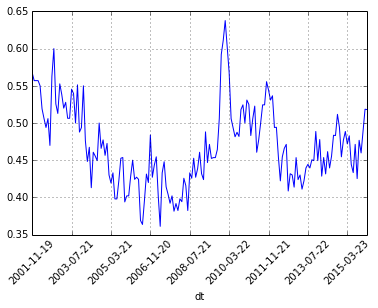

In [178]:
dfd = pd.read_csv(loc1 + '06_europe600_mvhd_selection_map_wgt.csv',sep=';')
dfa = dfd[-dfd.weight.isnull()]

x = dfa.groupby('dt').count()['isin']/dfd.groupby('dt').count()['isin']
x.plot()
plt.xticks(rotation=45)
x[x>0.8]


done


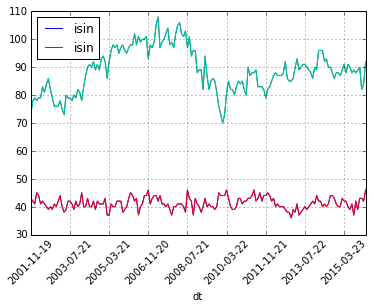

In [8]:
#Index factory files

#dfmap = dfmap[-dfmap.weight.isnull()]

#optimized weights
dfa = pd.read_csv(loc1 + '06_europe600_mvhd_selection_map_wgt.csv',sep=';')
dfa = dfa[-dfa.weight.isnull()]
cts0 = dfa.groupby('dt').count()['isin']
#print(cts0)
idxname = ['ISEMVHDP', 'ISEMVHDR', 'ISEMVHDG']
dfa['CUSIP'] = ''
for z in range(len(idxname)):
    for d in dfa.sort('dt', ascending=True)['dt'].drop_duplicates():
        dfif = dfa[(dfa.dt==d)][['sedol','CUSIP','isin','weight']]
        dfif.columns = ['SEDOL<string>','CUSIP<string>','ISIN<string>','Weight']
        dfif.to_csv(loc1 + 'index_factory/ISEMV/' + idxname[z] + '_' + str(d).replace('-','') + '.csv', float_format='%.9f',index=False)   
    
#equal weight
dfb = pd.read_csv(loc1 + '06_europe600_mvhd_selection_map_wgt.csv',sep=';')
cts = dfb.groupby('dt').count()['isin']
#print(cts)
dfb['weight'] = 0.
for i in range(len(cts)):
    dfb.loc[dfb[dfb.dt==cts.index[i]].index, 'weight'] = 1./cts[i]
    
idxname = ['ISEHDP', 'ISEHDR', 'ISEHDG']
dfb['CUSIP'] = ''
for z in range(len(idxname)):
    for d in dfb.sort('dt', ascending=True)['dt'].drop_duplicates():
        dfif = dfb[(dfb.dt==d)][['sedol','CUSIP','isin','weight']]
        dfif.columns = ['SEDOL<string>','CUSIP<string>','ISIN<string>','Weight']
        dfif.to_csv(loc1 + 'index_factory/ISEMV/' + idxname[z] + '_' + str(d).replace('-','') + '.csv', float_format='%.9f',index=False)

pd.concat([cts0,cts],axis=1).plot()
plt.xticks(rotation=45)
print('done')

In [30]:
#Feb 2016 ranks to load
loc_launch = 'G:/stoxx/STOXX/Product Development & Research/Projects/1881 OSSIAM Min Var High Div/09 Launch/'

dfrk = pd.read_csv(loc1 + '04_europe600_mvhd_selection_list.csv', sep=';')
dfrk = dfrk[(dfrk.dt=='2016-02-22') & (-dfrk.rankadtv.isnull())][['dt','symbol', 'rankadtv', 'rankdy0', 'new']].sort('rankadtv')
dfrk.columns = ['vd', 'DJ_ID', 'ADTV_rank', 'diy_yield_rank', 'component']
dfrk.to_csv(loc_launch + 'isemvhd_ranks_comps_feb2016.csv', sep=';', index=False)
print('done')

done


C:\Users\txg2a\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas-0.16.0-py3.4-win-amd64.egg\pandas\io\parsers.py:1164: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [186]:
#stats
#dff.head(10).sort('ffmcap', ascending=False)[['name','ICB_ind_name','country','ffmcap','cappedwgt']]
#pd.DataFrame(dfa[dfa.dt=='2016-01-25'].groupby('industry').sum()['weight']).sort('weight')
#pd.DataFrame(dfa[dfa.dt=='2016-01-25'].groupby('isocode').sum()['weight']).sort('weight').tail(10)
locdata = 'Y:/STOXX/'
idx = 'sxxp'
dat =  '20160125'

df = pd.read_csv(locdata + idx.lower() + '/close_' + idx.lower() + '_' + dat + '.csv', sep=';')
df = df[['Internal_Number','Instrument_Name','ICB','Country','Mcap_Units_Index_Currency','Weight']].sort('Weight', ascending=False)

a = dfa[dfa.dt=='2016-01-25'][['symbol','name','industry','isocode','weight']]
pd.merge(a, df[['Internal_Number','Mcap_Units_Index_Currency']], how='left', left_on='symbol', right_on='Internal_Number').sort('weight',ascending=False).head(10)

#benchmark
df.loc[df[df.ICB==533].index,'ICB'] = 0
df.loc[df[df.ICB==537].index,'ICB'] = 0
df.loc[df[df.ICB==573].index,'ICB'] = 0
df.loc[df[df.ICB==583].index,'ICB'] = 0
df['industry'] = df['ICB'].map(lambda x: str(x)[0]+'000')

#pd.DataFrame(df.groupby('industry').sum()['Weight']).sort('Weight')
pd.DataFrame(df.groupby('Country').sum()['Weight']).sort('Weight')

,Weight
Country,
CZ,0.06991
GR,0.08041
LU,0.20094
PT,0.23424
AT,0.27783
NO,0.82827
IE,0.91165
FI,1.71994
BE,2.21904


In [75]:
import sys
sys.path.append('G:/stoxx/STOXX/Product Development & Research/Python')
from stoxx.website import indexvalues as ix
from stoxx.stats import fullstats as sts

In [5]:
#4D
import sys
sys.path.append('G:/stoxx/STOXX/Product Development & Research/Python')
from stoxx.launch import upload_4d as u4d

df4d = pd.read_csv(loc1 + '06_europe600_mvhd_selection_map_wgt.csv',sep=';')
df4d = df4d[(df4d.dt=='2016-02-22') & -(df4d.weight.isnull())].reset_index(drop=True)

indexsymbol = 'ISEMVHDP'
cutdt = '20160216' #pricing cut of to calculate weightfactors

dfwf = u4d.get_4d_wf_file(df4d, cutdt, indexsymbol, 'symbol')
dfwf.to_csv(loc2 + 'isemvhdp_4d_weightfactor_'+ str(dt.date.today()).replace('-','') +'.csv' ,sep=';',index=False)

dfcomp = u4d.get_4d_comp_file(df4d, cutdt, indexsymbol, 'symbol')
dfcomp.to_csv(loc2 + 'isemvhdp_4d_composition_'+ str(dt.date.today()).replace('-','') +'.csv' ,sep=';',index=False)

print('done')

done


In [2]:
#Histories and divisors
import sys
import pandas as pd

sys.path.append('G:/stoxx/STOXX/Product Development & Research/Python')
from stoxx.launch import history_divisors as hd

loc_h = loc2 + 'histories_divisors/'
loc_if = loc1 + 'index_factory/output/'
rebdate = '2016-02-19' #'2015-12-31'

hd.get_hist_and_divs(loc_h, loc_if, rebdate)
print('done')

done


done


C:\Users\txg2a\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas-0.16.0-py3.4-win-amd64.egg\pandas\core\frame.py:1815: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


,ISEMVHDP Price,ISEMVHDR Net Return,ISEMVHDG Gross Return,ISEHD__P Price,ISEHD__R Net Return,ISEHD__G Gross Return,SXXP,SXXR,SXXGR,ISEMVP,ISEMVT,ISEMVGT
2016-02-23,158.056157,279.774241,311.433739,103.626567,182.823571,203.469955,109.354774,161.559270,173.645407,133.88,152.55,156.78
2016-02-24,155.343363,274.970543,306.085702,100.627119,177.530382,197.578419,106.835924,157.833355,169.643066,132.16,150.58,154.76
2016-02-25,158.588524,280.714448,312.479454,102.854761,181.538321,202.038777,108.941082,161.094807,173.212405,134.07,152.82,157.07
2016-02-26,160.039096,283.282914,315.338910,104.990590,185.308355,206.234674,110.609195,163.562588,175.857226,134.91,153.80,158.08
2016-02-29,160.953222,284.900535,317.139387,105.938070,186.979912,208.094684,111.403216,164.739058,177.132826,136.01,155.06,159.37


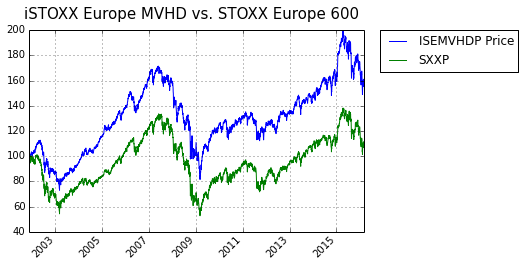

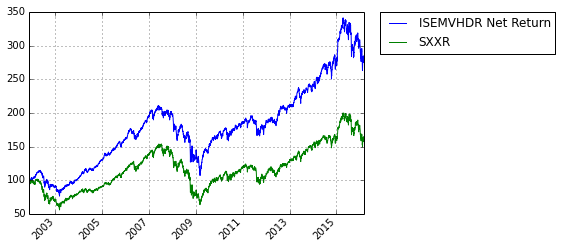

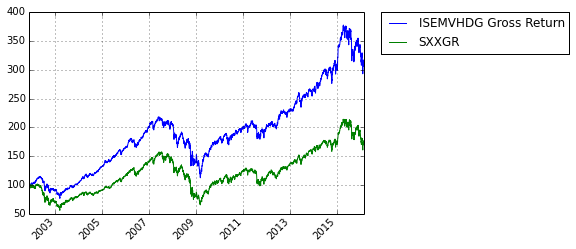

In [10]:
#if results
dfrom=dt.date(2000,1,1)
dto=dt.date(2016,3,10)
#['SXXP', 'SXXR', 'SXXGR'] 
df1=get_web_h(['SXXP', 'SXXR', 'SXXGR'], usedates=True, dfrom=dfrom, dto=dto) #Europe 600
df2=get_web_h(['ISEMVP', 'ISEMVT', 'ISEMVGT'], usedates=True, dfrom=dfrom, dto=dto, special=True) #iSTOXX Europe Min Var

#fs = ['17693 RuleModeler_ISEMVHDP (Price) EUR.csv',
#      '17694 RuleModeler_ISEMVHDR (Net Return) EUR.csv',
#      '17695 RuleModeler_ISEMVHDG (Gross Return) EUR.csv']

#fs = fs + ['17696 RuleModeler_ISEHD__P (Price) EUR.csv',
#           '17697 RuleModeler_ISEHD__R (Net Return) EUR.csv',
#           '17698 RuleModeler_ISEHD__G (Gross Return) EUR.csv']

fs = ['17959 RuleModeler_ISEMVHDP (Price) EUR.csv',
      '17960 RuleModeler_ISEMVHDR (Net Return) EUR.csv',
      '17961 RuleModeler_ISEMVHDG (Gross Return) EUR.csv']

fs = fs + ['17962 RuleModeler_ISEHD__P (Price) EUR.csv',
           '17963 RuleModeler_ISEHD__R (Net Return) EUR.csv',
           '17964 RuleModeler_ISEHD__G (Gross Return) EUR.csv']

ct=0
for f in fs:
    ct=ct+1
    col_idx = f[18:27] + f[28:len(f)-9]
    #col_idx = 'ISEHD_' + f[26:len(f)-9]
    dfif = pd.read_csv(loc1+'index_factory/output/'+ f, sep=';', names=['Date', col_idx])
    dfif['Date'] = pd.to_datetime(dfif['Date'], format='%Y-%m-%d', dayfirst=True)
    dfif = dfif.sort('Date',ascending=True)
    if ct>1:
        dfif2 = pd.merge(dfif2, dfif, how='left', on='Date')
    else:
        dfif2 = dfif

dfif2 = dfif2[dfif2.Date>=df1.iloc[0,0]]
dfif2 = dfif2[dfif2.Date>='2001-11-19']
dfif1 = pd.merge(dfif2, df1, how='left', on='Date')
dfif1 = pd.merge(dfif1, df2, how='left', on='Date')

calc1 = calc_stats_sharpe_ext(dfif1.iloc[:,[0,1,2,3]]) #iSTOXX MVHD
calc1.iloc[:,:-1] = np.around(calc1.iloc[:,:-1].astype(np.double), decimals=4)

calc2 = calc_stats_sharpe_ext(dfif1.iloc[:,[0,7,8,9]]) #Benchmark
calc2.iloc[:,:-1] = np.around(calc2.iloc[:,:-1].astype(np.double), decimals=4)

calc3 = calc_stats_sharpe_ext(dfif1.iloc[:,[0,4,5,6]]) #iSTOXX HD
calc3.iloc[:,:-1] = np.around(calc3.iloc[:,:-1].astype(np.double), decimals=4)

calc4 = calc_stats_sharpe_ext(dfif1.iloc[:,[0,10,11,12]]) #iSTOXX Europe Min Var (existing) as Bm
calc4.iloc[:,:-1] = np.around(calc4.iloc[:,:-1].astype(np.double), decimals=4)

dfif1 = dfif1.set_index(['Date'], drop=True)
dfif1.index.name= None
 
dfif1.iloc[:,:9] = dfif1.iloc[:,:9] / dfif1.iloc[0,:9] * 100
dfif1 = dfif1.fillna(method='pad')

dfif1.iloc[:,[0,6]].plot() #[0,6] [0,9]
plt.suptitle('iSTOXX Europe MVHD vs. STOXX Europe 600', fontsize=15)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=45)
dfif1.iloc[:,[1,7]].plot() #[1,7] [1,10]
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=45)
dfif1.iloc[:,[2,8]].plot() #[2,8] [2,11]
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=45)

dfif1.to_csv(loc1+'index_factory/ismvhd_timeseries_full_20160301.csv', sep=';',index=True)
print('done')
dfif1.iloc[:,:].tail()

In [11]:
#get export compare for Ossiam
dfi = pd.merge(dfif2, df1, how='left', on='Date')
dfi = pd.merge(dfi, df2, how='left', on='Date')
dfi = dfi.iloc[:,[0,1,2,3,7,8,9,10,11,12]]
dfi = dfi.set_index(['Date'], drop=True)
dfi.index.name= None

dfi.iloc[:,[0,1,2,3,4,5]] = dfi.iloc[:,[0,1,2,3,4,5]] / dfi.iloc[0,[0,1,2,3,4,5]] * 100
dfi.iloc[:,[0,1,2,3,4,5]] = dfi.iloc[:,[0,1,2,3,4,5]].fillna(method='pad')
dfi.iloc[30:,[6,7,8]] = dfi.iloc[30:,[6,7,8]].fillna(method='pad')
dfi.to_csv(loc1+'index_factory/ismvhd_timeseries_20160301.csv', sep=';',index=True)
dfi.head(2)

,ISEMVHDP Price,ISEMVHDR Net Return,ISEMVHDG Gross Return,SXXP,SXXR,SXXGR,ISEMVP,ISEMVT,ISEMVGT
2001-11-19,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,NaN,NaN,NaN
2001-11-20,99.696209,99.696209,99.696209,98.832321,98.833737,98.829725,NaN,NaN,NaN


In [199]:
dfi.tail(2)

,ISEMVHDP Price,ISEMVHDR Net Return,ISEMVHDG Gross Return,SXXP,SXXR,SXXGR,ISEMVP,ISEMVT,ISEMVGT
2016-02-05,161.476570,286.689268,319.066093,114.505905,168.842669,181.439438,NaN,NaN,NaN
2016-02-08,156.322164,277.538017,308.881359,114.505905,168.842669,181.439438,NaN,NaN,NaN


net_dy      0.043093
gross_dy    0.051300
tax         0.159746
dtype: float64


,net_dy,gross_dy,tax
2002,0.0322,0.0363,0.112948
2003,0.0499,0.0580,0.139655
2004,0.0408,0.0466,0.124464
2005,0.0423,0.0504,0.160714
2006,0.0438,0.0524,0.164122
2007,0.0333,0.0401,0.169576
2008,0.0306,0.0400,0.235000
2009,0.0539,0.0682,0.209677
2010,0.0396,0.0491,0.193483
2011,0.0493,0.0587,0.160136


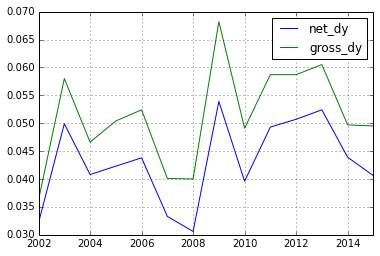

In [12]:
calc1
calc_an_div_yields(dfif2.iloc[:,:4]).plot()
dy = calc_an_div_yields(dfif2.iloc[:,:4])
dy['tax'] = 1 - (dy.iloc[:,0] / dy.iloc[:,1])
print(dy.mean())
dy

In [13]:
calc1

ISEMVHDP Price  ISEMVHDR Net Return  \
return actual         0          0.6095               1.8490   
                      1          0.2044               0.4957   
                      2          0.1867               0.3377   
                      3         -0.1449              -0.1118   
                      4         -0.0709              -0.0680   
                      5         -0.0388              -0.0370   
return ann.           0          0.0330               0.0740   
                      1          0.0369               0.0816   
                      2          0.0573               0.0993   
                      3         -0.1418              -0.1093   
                      4         -0.3612              -0.3492   
                      5         -0.3758              -0.3619   
volatility ann.       0          0.1530               0.1531   
                      1          0.1402               0.1401   
                      2          0.1455               0.1454   
                      3          0.1972               0.1970   
                      4          0.2590               0.2592   
                      5          0.2776               0.2780   
dividend yield ann.   0             NaN               0.0410   
                      1             NaN               0.0447   
                      2             NaN               0.0420   
                      3             NaN               0.0325   
                      4             NaN               0.0119   
                      5             NaN               0.0138   
Sharpe ratio EUR ann. 0          0.1876               0.4421   
                      1          0.3194               0.6211   
                      2          0.4570               0.7256   
                      3         -0.6355              -0.4473   
                      4         -1.1589              -1.0940   
                      5         -1.6040              -1.5204   
max drawdown          0          0.5246               0.4932   
                      1          0.2526               0.2291   
                      2          0.2526               0.2291   
                      3          0.2526               0.2291   
                      4          0.1244               0.1232   
                      5          0.1109               0.1104   

                         ISEMVHDG Gross Return            period  
return actual         0                 2.1714  as of 2001-11-19  
                      1                 0.5507                5y  
                      2                 0.3644                3y  
                      3                -0.1042                1y  
                      4                -0.0677               YTD  
                      5                -0.0369                1m  
return ann.           0                 0.0819  as of 2001-11-19  
                      1                 0.0892                5y  
                      2                 0.1064                3y  
                      3                -0.1019                1y  
                      4                -0.3477               YTD  
                      5                -0.3611                1m  
volatility ann.       0                 0.1532  as of 2001-11-19  
                      1                 0.1400                5y  
                      2                 0.1454                3y  
                      3                 0.1970                1y  
                      4                 0.2592               YTD  
                      5                 0.2781                1m  
dividend yield ann.   0                 0.0489  as of 2001-11-19  
                      1                 0.0523                5y  
                      2                 0.0491                3y  
                      3                 0.0399                1y  
                      4                 0.0135               YTD  
                      5                 0.0147  

In [14]:
calc3

ISEHD__P Price  ISEHD__R Net Return  \
return actual         0          0.0594               0.8698   
                      1          0.0644               0.3112   
                      2          0.1495               0.2912   
                      3         -0.1845              -0.1548   
                      4         -0.0756              -0.0721   
                      5         -0.0161              -0.0139   
return ann.           0          0.0039               0.0436   
                      1          0.0122               0.0542   
                      2          0.0464               0.0867   
                      3         -0.1806              -0.1515   
                      4         -0.3807              -0.3665   
                      5         -0.1759              -0.1537   
volatility ann.       0          0.2184               0.2184   
                      1          0.1878               0.1877   
                      2          0.1728               0.1728   
                      3          0.2311               0.2312   
                      4          0.3339               0.3344   
                      5          0.3666               0.3671   
dividend yield ann.   0             NaN               0.0397   
                      1             NaN               0.0420   
                      2             NaN               0.0404   
                      3             NaN               0.0291   
                      4             NaN               0.0142   
                      5             NaN               0.0223   
Sharpe ratio EUR ann. 0          0.0579               0.2354   
                      1          0.1537               0.3701   
                      2          0.3580               0.5771   
                      3         -0.7146              -0.5631   
                      4         -0.7941              -0.7249   
                      5         -0.1781              -0.1069   
max drawdown          0          0.7366               0.7195   
                      1          0.3042               0.2848   
                      2          0.3042               0.2848   
                      3          0.3042               0.2848   
                      4          0.1475               0.1458   
                      5          0.1107               0.1103   

                         ISEHD__G Gross Return            period  
return actual         0                 1.0809  as of 2001-11-19  
                      1                 0.3731                5y  
                      2                 0.3237                3y  
                      3                -0.1487                1y  
                      4                -0.0716               YTD  
                      5                -0.0137                1m  
return ann.           0                 0.0513  as of 2001-11-19  
                      1                 0.0637                5y  
                      2                 0.0956                3y  
                      3                -0.1455                1y  
                      4                -0.3642               YTD  
                      5                -0.1512                1m  
volatility ann.       0                 0.2184  as of 2001-11-19  
                      1                 0.1877                5y  
                      2                 0.1728                3y  
                      3                 0.2312                1y  
                      4                 0.3345               YTD  
                      5                 0.3673                1m  
dividend yield ann.   0                 0.0473  as of 2001-11-19  
                      1                 0.0515                5y  
                      2                 0.0492                3y  
                      3                 0.0351                1y  
                      4                 0.0166               YTD  
                      5                 0.0247  

In [15]:
calc4

ISEMVP  ISEMVT  ISEMVGT            period
return actual         0     NaN     NaN      NaN  as of 2001-11-19
                      1  0.3824  0.6037   0.6539                5y
                      2  0.2555  0.3584   0.3815                3y
                      3 -0.0795 -0.0580  -0.0532                1y
                      4 -0.0551 -0.0531  -0.0528               YTD
                      5 -0.0175 -0.0168  -0.0167                1m
return ann.           0     NaN     NaN      NaN  as of 2001-11-19
                      1  0.0651  0.0964   0.1030                5y
                      2  0.0769  0.1048   0.1109                3y
                      3 -0.0777 -0.0567  -0.0520                1y
                      4 -0.2922 -0.2829  -0.2815               YTD
                      5 -0.1894 -0.1827  -0.1819                1m
volatility ann.       0  0.1256  0.1256   0.1257  as of 2001-11-19
                      1  0.1227  0.1226   0.1225                5y
                      2  0.1293  0.1292   0.1292                3y
                      3  0.1747  0.1745   0.1745                1y
                      4  0.2246  0.2243   0.2241               YTD
                      5  0.2304  0.2308   0.2308                1m
dividend yield ann.   0     NaN     NaN      NaN  as of 2001-11-19
                      1     NaN  0.0313   0.0379                5y
                      2     NaN  0.0280   0.0340                3y
                      3     NaN  0.0210   0.0257                1y
                      4     NaN  0.0093   0.0106               YTD
                      5     NaN  0.0067   0.0075                1m
Sharpe ratio EUR ann. 0     NaN     NaN      NaN  as of 2001-11-19
                      1  0.5614  0.7976   0.8464                5y
                      2  0.6369  0.8359   0.8784                3y
                      3 -0.3134 -0.1845  -0.1560                1y
                      4 -0.7796 -0.7414  -0.7377               YTD
                      5 -1.0349 -0.9955  -0.9986                1m
max drawdown          0  0.0000  0.0000   0.0000  as of 2001-11-19
                      1  0.1955  0.1806   0.1768                5y
                      2  0.1955  0.1806   0.1768                3y
                      3  0.1955  0.1806   0.1768                1y
                      4  0.1054  0.1048   0.1047               YTD
                      5  0.0924  0.0924   0.0924                1m

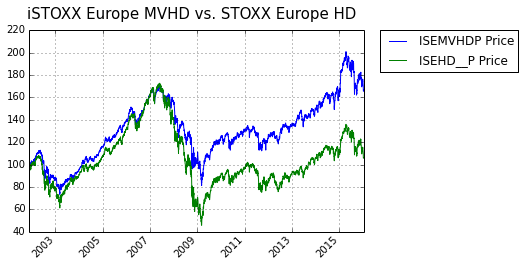

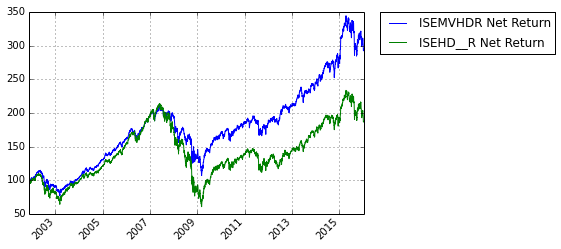

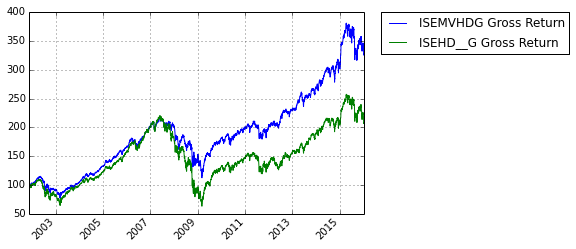

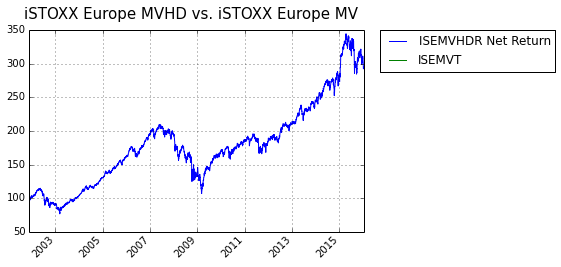

In [44]:
#dfif1 = dfif1[dfif1.index>='2011-10-01']
dfif1 = dfif1 / dfif1.iloc[0,:] * 100
dfif1.iloc[:,[0,3]].plot()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.suptitle('iSTOXX Europe MVHD vs. STOXX Europe HD', fontsize=15)
plt.xticks(rotation=45)
dfif1.iloc[:,[1,4]].plot()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=45)
dfif1.iloc[:,[2,5]].plot()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=45)
#dfif1.iloc[:,:].tail()

dfif1.iloc[:,[1,10]].plot()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=45)
plt.suptitle('iSTOXX Europe MVHD vs. iSTOXX Europe MV', fontsize=15)

In [3]:
get_infocode('ES0162601019')

39402

In [36]:
t=to.calc_turnover_df(df1, 'm')
t
                      

,year,month,turnover
0,2000,12,0.000000
1,2001,3,0.000000
2,2001,6,0.000000
3,2001,9,0.000000
4,2001,11,NaN
5,2001,12,0.166685
6,2002,1,0.171925
7,2002,2,0.101973
8,2002,3,0.151158
9,2002,4,0.200816


mean turnover: 0.183362054545


C:\Users\txg2a\AppData\Local\Continuum\Anaconda3\lib\site-packages\pandas-0.16.0-py3.4-win-amd64.egg\pandas\io\parsers.py:1164: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


,year,month,turnover
0,2002,6,0.178914
1,2002,9,0.230920
2,2002,12,0.204913
3,2003,3,0.168372
4,2003,6,0.237762
5,2003,9,0.236963
6,2003,12,0.110084
7,2004,3,0.120649
8,2004,6,0.217280
9,2004,9,0.147406


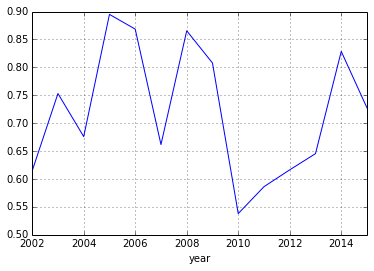

In [17]:
#index turnover
df1 = pd.read_csv(loc1+'index_factory/output/'+ 'IndexReport_RuleModeler_ISEMVHDP (Price).csv', sep=';')

import stoxx.stats.turnover as to

t=to.calc_turnover_df(df1, 'q')

t = t[6:].reset_index(drop=True)
t.groupby('year').sum()['turnover'][:].plot()
#t['turnover'][:].plot()

t.iloc[:,-1:] = np.around(t.iloc[:,-1:].astype(np.double), decimals=6)
print('mean turnover:', t['turnover'].mean())
t

In [156]:
#optimization with cvxopt
%run -i min_var_high_div.py

dfin = pd.read_csv(loc1 + '04_europe600_mvhd_selection.csv', sep=';')

dfmain = pd.read_csv(loc1 + '05_europe600_mvhd_princing.csv', sep=';')
dfmain.fillna(method='pad', inplace=True)

returnscorr=np.array(dfmain.iloc[1:len(dfmain),1:])/np.array(dfmain.iloc[0:len(dfmain)-1,1:])
dfmainvol=dfmain[dfmain.dt>=dfin.loc[1,'dt-120']].reset_index(drop=True) #120 observations
returnsvol=np.array(dfmainvol.iloc[1:len(dfmainvol),1:])/np.array(dfmainvol.iloc[0:len(dfmainvol)-1,1:])

#dfrcorr=pd.DataFrame(returnscorr)
#dfrcorr.columns=dfmain.columns[1:]
#dfrvol=pd.DataFrame(returnsvol)
#dfrvol.columns=dfmain.columns[1:]

covscorr= np.cov(returnscorr.T)*252 #500 obs
corrs=np.diag(np.diag(covscorr)) #diagonal with covariances using 500 obs
covsvol= np.cov(returnsvol.T)*252 #120 obs
vols=covsvol-np.diag(np.diag(covsvol)) #zeros in the diagonal
covs=vols+corrs

dfin=dfin.loc[:,['sedol', 'industry', 'name']]

#calling optimization function
optwgts=opti_mvhd(dfmain, dfin, covs)
print('-----------')
#checks:
print('Portfolio variance -- ', np.dot(optwgts.T,np.dot(covs,optwgts)))
print('weights greater than 4.5% --', [optwgts>0.045]==True) #weights greater than 4.5%
print('weights below zero --', [optwgts<0.]==True) #weights below 0
print('sum of weights -- ', sum(optwgts)) #sum 100%

industryidx=list()
industry=[]
for i in np.unique(list(dfin.industry)):
    industry.append(i)
    industryidx.append(dfin[dfin['industry']==i]['sedol'].index)
for i in range(10):       
    print ('industry', industry[i], '--', sum(optwgts[industryidx[i]])) #industry sum weights
   
print('Hefindhal -- ', 1./(np.dot(optwgts.T,optwgts))) #variance

plt.bar(range(0,len(covs)),optwgts)

#print(pd.DataFrame(optwgts, dfmain.columns[1:]))

KeyError: 'the label [dt-120] is not in the [index]'

In [160]:
#min var optimization scipy - sector constraint

%run -i min_var_high_div.py

dfin = pd.read_csv(loc1 + '04_europe600_mvhd_selection.csv', sep=';')
dfin = dfin[dfin.dt=='2015-04-21'].reset_index()

dfmain = pd.read_csv(loc1 + '05_europe600_mvhd_princing.csv', sep=';')
dfmain.fillna(method='pad', inplace=True)

returnscorr=np.array(dfmain.iloc[1:len(dfmain),1:])/np.array(dfmain.iloc[0:len(dfmain)-1,1:])
dfmainvol=dfmain[dfmain.dt>=dfin.loc[1,'dt-125']].reset_index(drop=True) #120 observations
returnsvol=np.array(dfmainvol.iloc[1:len(dfmainvol),1:])/np.array(dfmainvol.iloc[0:len(dfmainvol)-1,1:])

covscorr= np.cov(returnscorr.T)*252 #500 obs
corrs=np.diag(np.diag(covscorr)) #diagonal with covariances using 500 obs
covsvol= np.cov(returnsvol.T)*252 #120 obs
vols=covsvol-np.diag(np.diag(covsvol)) #zeros in the diagonal
covs=vols+corrs

w_max=0.045
H=50.
ind_max=0.2

industryidx=list()
for i in np.unique(list(dfin.industry)):
    industryidx.append(dfin[dfin['industry']==i]['sedol'].index)

from scipy.optimize import minimize

def port_var(w):
    return np.dot(w,np.dot(covs,w))

b_ = [(0.,w_max) for i in range(len(covs))]
c_ = ({'type':'eq', 'fun': lambda w: np.dot(w,w)-1./H},
      {'type':'eq', 'fun': lambda w: sum(w)-1.},
      {'type':'ineq', 'fun': lambda w: sum(w[np.array(industryidx[0])])-ind_max},
      {'type':'ineq', 'fun': lambda w: sum(w[np.array(industryidx[1])])-ind_max},
      {'type':'ineq', 'fun': lambda w: sum(w[np.array(industryidx[2])])-ind_max},
      {'type':'ineq', 'fun': lambda w: sum(w[np.array(industryidx[3])])-ind_max},
      {'type':'ineq', 'fun': lambda w: sum(w[np.array(industryidx[4])])-ind_max},
      {'type':'ineq', 'fun': lambda w: sum(w[np.array(industryidx[5])])-ind_max},
      {'type':'ineq', 'fun': lambda w: sum(w[np.array(industryidx[6])])-ind_max},
      {'type':'ineq', 'fun': lambda w: sum(w[np.array(industryidx[7])])-ind_max},
      {'type':'ineq', 'fun': lambda w: sum(w[np.array(industryidx[8])])-ind_max},
      {'type':'ineq', 'fun': lambda w: sum(w[np.array(industryidx[9])])-ind_max}) 

w0=ones(len(covs))/len(covs)

optiwgts = minimize(port_var, w0, method='SLSQP', bounds=b_, constraints=c_)
optiwgts.x

array([ 0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,
        0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,
        0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,
        0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,
        0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,
        0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,
        0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,
        0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,
        0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,
        0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,
        0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01,  0.01])

In [154]:
optiwgts.x

dfopti=pd.DataFrame(optiwgts.x)
dfopti=np.round(dfopti,7)
dfopti['sedol']=dfin['sedol']
cols=dfopti.columns.tolist()
dfopti=dfopti[cols[-1:] + cols[:-1]] #rearrange column order
dfopti=dfopti.rename(columns={dfopti.columns[1]:'weight'})
dfopti=dfopti.sort('weight', ascending=False)

dfopti=pd.merge(dfopti, dfin, how='left', on='sedol')
dfopti.index=dfopti.sedol
del dfopti['sedol']
dfopti.index.name=None
#dfopti.head()

KeyError: 'sedol'

In [77]:
#optimization with cvxopt
dfin = pd.read_csv(loc1 + '04_europe600_mvhd_selection.csv', sep=';')
dfmain = pd.read_csv(loc1 + '05_europe600_mvhd_princing.csv', sep=';')
dfmain.fillna(method='pad', inplace=True)

returnscorr=array(dfmain.iloc[1:len(dfmain),1:])/array(dfmain.iloc[0:len(dfmain)-1,1:])
dfmainvol=dfmain[dfmain.dt>=dfin.loc[1,'dt-120']].reset_index(drop=True) #120 observations
returnsvol=array(dfmainvol.iloc[1:len(dfmainvol),1:])/array(dfmainvol.iloc[0:len(dfmainvol)-1,1:])

#dfrcorr=pd.DataFrame(returnscorr)
#dfrcorr.columns=dfmain.columns[1:]
#dfrvol=pd.DataFrame(returnsvol)
#dfrvol.columns=dfmain.columns[1:]

covscorr= np.cov(returnscorr.T)*252 #500 obs
corrs=np.diag(np.diag(covscorr)) #diagonal with covariances using 500 obs
covsvol= np.cov(returnsvol.T)*252 #120 obs
vols=covsvol-np.diag(np.diag(covsvol)) #zeros in the diagonal
covs=vols+corrs
#pd.DataFrame(covs).head()
dfin=dfin.loc[:,['sedol', 'industry', 'name']]

### Optimization
    
# minimize    (1/2)*x'*P*x + q'*x 
# subject to  G*x <= h      
#             A*x = b

n= len(covs)
ni = 10 #num industries

P = matrix(covs+np.eye(n))
A = matrix(np.ones((1,n)))
b = matrix(np.ones((1,1)))
g = np.zeros((ni,n))
q = matrix(np.zeros((n,1)))

industryidx=list()
for i in np.unique(list(dfin.industry)):
    industryidx.append(dfin[dfin['industry']==i]['sedol'].index)

for i in range(ni):
    g[i,industryidx[i]]=1

G = matrix(np.concatenate((g,np.eye(100)),0))
h = matrix(np.concatenate((0.2*np.ones((ni,1)), 0.045*np.ones((100,1))),0))

sol=solvers.qp(P, q, G, h, A, b)

optwgtst=np.array(sol['x'])

#check opti values
print(optwgts)
print(sol['x'])
print (np.dot(optwgts,np.dot(covs,optwgts)))


for i in range(ni):       
    print (sum(optwgtst[industryidx[i]]))
   
print (np.dot(optwgtst.T,optwgtst))

plt.bar(range(0,n),sol['x'])

ValueError: use of function valued P, G, A requires a user-provided kktsolver

In [70]:
#optimization
dfin = pd.read_csv(loc1 + '04_europe600_mvhd_selection.csv', sep=';')
dfmain = pd.read_csv(loc1 + '05_europe600_mvhd_princing.csv', sep=';')
dfmain.fillna(method='pad', inplace=True)

returnscorr=array(dfmain.iloc[1:len(dfmain),1:])/array(dfmain.iloc[0:len(dfmain)-1,1:])
dfmainvol=dfmain[dfmain.dt>=dfin.loc[1,'dt-125']].reset_index(drop=True) #120 observations
returnsvol=array(dfmainvol.iloc[1:len(dfmainvol),1:])/array(dfmainvol.iloc[0:len(dfmainvol)-1,1:])

#dfrcorr=pd.DataFrame(returnscorr)
#dfrcorr.columns=dfmain.columns[1:]
#dfrvol=pd.DataFrame(returnsvol)
#dfrvol.columns=dfmain.columns[1:]

covscorr= np.cov(returnscorr.T)*252 #500 obs
corrs=np.diag(np.diag(covscorr)) #diagonal with covariances using 500 obs
covsvol= np.cov(returnsvol.T)*252 #120 obs
vols=covsvol-np.diag(np.diag(covsvol)) #zeros in the diagonal
covs=vols+corrs
#pd.DataFrame(covs).head()
dfin=dfin.loc[:,['sedol', 'industry', 'name']]

n= len(covs)
ni = 10 #num industries

In [79]:
#calculate returns
#dfmain=dfmain.iloc[:6,:]
dfmain.fillna(method='pad', inplace=True)
del dfmain['dt']
returns=array(dfmain.iloc[1:len(dfmain),:])/array(dfmain.iloc[0:len(dfmain)-1,:])
dfr=pd.DataFrame(returns)
dfr.index=dfmain.index[1:]
dfr.columns=dfmain.columns

#calculate covarianc matrix
covs= np.cov(returns.T)*252
dfcov=pd.DataFrame(covs)
#dfcorr=pd.DataFrame(np.corrcoef(returns.T))
dfcov.columns=dfmain.columns
dfcov.index=dfmain.columns
variances= [np.var(np.array(dfr.iloc[:,i]), ddof=1)*252 for i in range(len(dfr.columns))] #checking the variances in the main diagonal
volas= [np.std(np.array(dfr.iloc[:,i]), ddof=1)*np.sqrt(252) for i in range(len(dfr.columns))]
#dfcov
dfr.iloc[:,:1].hist(bins=20)

KeyError: 'dt'

In [78]:
dfin=pd.read_excel(loc+'index_symbols.xlsx', sheetname='300')
dfin=dfin[['Symbol','ICB','Full Name']]
#dfin.head()

dfmain=pd.read_excel(loc+'h_prod.xlsx')
pd.to_datetime(dfmain.index, format='%d.%m.%Y', dayfirst=True)
dfmain=dfmain.iloc[4683:,:]
dfmain=dfmain/dfmain.iloc[0,:]*100 #rebase
print (len(dfmain))
dfmain.plot()

KeyboardInterrupt: 

In [158]:
#calculate returns
#dfmain=dfmain.iloc[:6,:]
dfmain.fillna(method='pad', inplace=True)
returns=array(dfmain.iloc[1:len(dfmain),:])/array(dfmain.iloc[0:len(dfmain)-1,:])
dfr=pd.DataFrame(returns)
dfr.index=dfmain.index[1:]
dfr.columns=dfmain.columns

#calculate covarianc matrix
covs= np.cov(returns.T)*252
dfcov=pd.DataFrame(covs)
#dfcorr=pd.DataFrame(np.corrcoef(returns.T))
dfcov.columns=dfmain.columns
dfcov.index=dfmain.columns
variances= [np.var(np.array(dfr.iloc[:,i]), ddof=1)*252 for i in range(len(dfr.columns))] #checking the variances in the main diagonal
volas= [np.std(np.array(dfr.iloc[:,i]), ddof=1)*np.sqrt(252) for i in range(len(dfr.columns))]
#dfcov
dfr.iloc[:,:1].hist(bins=20)

TypeError: unsupported operand type(s) for /: 'str' and 'str'

In [13]:
lvwgt=(array(volas)**(-1))/sum(array(volas)**(-1)) #low risk weighted
list(lvwgt)
a_returns=array([sum(returns.T[i]/len(dfr)) for i in range(len(dfr.columns))])*252 #annualized returns

#portfolio return based on low risk weights
return_p = np.dot(lvwgt,a_returns)
#portfolio variance based on low risk
variance_p = np.dot(lvwgt,np.dot(covs,lvwgt))

rskfree=0.05
sharpe_rts=list((a_returns-rskfree)/list(volas)) #sharpe ratio

In [14]:
#sector weight constraint
def ind_exp_constraint(, i_max):
    cons=1
    return cons

cons=ind_exp_constraint(20.)
cons

SyntaxError: invalid syntax (<ipython-input-14-59df904af950>, line 2)

In [157]:
#min var optimization
w_max=0.045
H=50.

from scipy.optimize import minimize
def port_var(w):
    return np.dot(w,np.dot(covs,w))

b_ = [(0.,w_max) for i in range(len(dfr.columns))]
c_ = ({'type':'ineq', 'fun': lambda w: np.dot(w,w)-1./H},
      {'type':'eq', 'fun': lambda w: sum(w)-1.}) 

w0=ones(len(dfr.columns))/len(dfr.columns)


dfopti=pd.DataFrame(optiwgts.x)
dfopti=np.round(dfopti,7)
dfopti['Symbol']=dfr.columns
cols=dfopti.columns.tolist()
dfopti=dfopti[cols[-1:] + cols[:-1]] #rearrange column order
dfopti=dfopti.rename(columns={dfopti.columns[1]:'weight'})
dfopti=dfopti.sort('weight', ascending=False)

dfopti=pd.merge(dfopti, dfin, how='left', on='Symbol')
dfopti.index=dfopti.Symbol
del dfopti['Symbol']
dfopti.index.name=None
dfopti.head()

optiwgts = minimize(port_var, w0, method='SLSQP', bounds=b_, constraints=c_)
optiwgts.x

KeyError: 'Symbol'

In [93]:
print ('Herfindahl -',  1./np.dot(optiwgts.x,optiwgts.x))

Herfindahl - 23.9576101817


In [82]:

print ('Herfindahl -',  1./np.dot(optiwgts.x,optiwgts.x))
print ('Total weight -', sum(dfopti.weight))
dfopti.groupby('ICB').sum()

Herfindahl - 100.0
Total weight - 1.0


,weight
ICB,


In [20]:
#{'type':'eq', 'fun': lambda w: sum(w[0:indendposix[0]])-0.2}

#min var optimization - sector constraint
w_max=0.045
H=50.
ind_max=0.2

industryidx=list()
dftemp=pd.DataFrame({'symbol':dfr.columns,'ICB':dfin.ICB})
for i in np.unique(list(dfin.ICB)):
    industryidx.append(dftemp[dftemp['ICB']==i]['symbol'].index)

from scipy.optimize import minimize
def port_var(w):
    return np.dot(w,np.dot(covs,w))

b_ = [(0.,w_max) for i in range(len(dfr.columns))]
c_ = ({'type':'eq', 'fun': lambda w: np.dot(w,w)-1./H},
      {'type':'eq', 'fun': lambda w: sum(w)-1.},
      {'type':'ineq', 'fun': lambda w: sum(w[industryidx[0]])-ind_max},
      {'type':'ineq', 'fun': lambda w: sum(w[industryidx[1]])-ind_max},
      {'type':'ineq', 'fun': lambda w: sum(w[industryidx[2]])-ind_max},
      {'type':'ineq', 'fun': lambda w: sum(w[industryidx[3]])-ind_max},
      {'type':'ineq', 'fun': lambda w: sum(w[industryidx[4]])-ind_max},
      {'type':'ineq', 'fun': lambda w: sum(w[industryidx[5]])-ind_max},
      {'type':'ineq', 'fun': lambda w: sum(w[industryidx[6]])-ind_max},
      {'type':'ineq', 'fun': lambda w: sum(w[industryidx[7]])-ind_max},
      {'type':'ineq', 'fun': lambda w: sum(w[industryidx[8]])-ind_max},
      {'type':'ineq', 'fun': lambda w: sum(w[industryidx[9]])-ind_max}
      ) 


w0=ones(len(dfr.columns))/len(dfr.columns)

optiwgts = minimize(port_var, w0, method='SLSQP', bounds=b_, constraints=c_)

dfopti=pd.DataFrame(optiwgts.x)
dfopti=np.round(dfopti,7)
dfopti['Symbol']=dfr.columns
cols=dfopti.columns.tolist()
dfopti=dfopti[cols[-1:] + cols[:-1]] #rearrange column order
dfopti=dfopti.rename(columns={dfopti.columns[1]:'weight'})
dfopti=dfopti.sort('weight', ascending=False)

dfopti=pd.merge(dfopti, dfin, how='left', on='Symbol')
dfopti.index=dfopti.Symbol
del dfopti['Symbol']
dfopti.index.name=None
dfopti.head()

IndexError: unsupported iterator index

In [446]:
print 'Herfindahl -',  1./np.dot(optiwgts.x,optiwgts.x)
print 'Total weight -', sum(dfopti.weight)
dfopti.groupby('ICB').sum()

Herfindahl - 109.809431346
Total weight - 1.0000007


,weight
ICB,
1,0.040395
1000,0.116955
2000,0.110498
3000,0.187110
4000,0.056337
5000,0.161584
6000,0.053179
7000,0.043461
8000,0.163192


In [375]:
dftemp=pd.DataFrame({'symbol':dfr.columns,'ICB':dfin.ICB})
for i in np.unique(list(dfin.ICB)):
    industryidx= dftemp[dftemp['ICB']==i]['symbol'].index
    #print np.array(industryidx)
    

In [21]:
#min var optimization - sector constraint with fmin_slsqp
#alt:  fmin_cobyla, fmin_tnc, fmin_l_bfgs_b or OpenOpt solvers
from scipy.optimize import fmin_slsqp, fmin_cobyla, fmin_tnc, fmin_l_bfgs_b

#constraints
w_max=0.045
H=50.
ind_max=0.2

#target function
def port_var(w):
    return np.dot(w,np.dot(covs,w))

#equality constraint functions
def ec1(w):
    return np.dot(w,w)-1./H
def ec2(w):
    return sum(w)-1.

#inequality constraint functions
#inec_=list()
industryidx=list()
dftemp=pd.DataFrame({'symbol':dfr.columns,'ICB':dfin.ICB})
for i in np.unique(list(dfin.ICB)):
    industryidx.append(dftemp[dftemp['ICB']==i]['symbol'].index)
    #inec_.append(lambda w: sum(w[industryidx])-ind_max)
    #def inec(w):
     #   return sum(w[industryidx])-ind_max

def inec1(w):
    return sum(w[industryidx[0]])-ind_max
def inec2(w):
    return sum(w[industryidx[1]])-ind_max
def inec3(w):
    return sum(w[industryidx[2]])-ind_max
def inec4(w):
    return sum(w[industryidx[3]])-ind_max
def inec5(w):
    return sum(w[industryidx[4]])-ind_max
def inec6(w):
    return sum(w[industryidx[5]])-ind_max
def inec7(w):
    return sum(w[industryidx[6]])-ind_max
def inec8(w):
    return sum(w[industryidx[7]])-ind_max
def inec9(w):
    return sum(w[industryidx[8]])-ind_max
def inec10(w):
    return sum(w[industryidx[9]])-ind_max

w0=ones(len(dfr.columns))/len(dfr.columns)
b_ = [(0.,w_max) for i in range(len(dfr.columns))]

optiwgts = fmin_slsqp(port_var, 
                      w0,
                      eqcons=[ec1, ec2],
                      #ieqcons=[(lambda w: sum(w[industryidx[j]])-ind_max) for j in range(len(industryidx))],
                      ieqcons=[inec1, inec2, inec3, inec4, inec5, inec6, inec7, inec8, inec9, inec10], 
                      bounds=b_)

dfopti=pd.DataFrame(optiwgts)
dfopti=np.round(dfopti,7)
dfopti['Symbol']=dfr.columns
cols=dfopti.columns.tolist()
dfopti=dfopti[cols[-1:] + cols[:-1]] #rearrange column order
dfopti=dfopti.rename(columns={dfopti.columns[1]:'weight'})
dfopti=dfopti.sort('weight', ascending=False)

dfopti=pd.merge(dfopti, dfin, how='left', on='Symbol')
dfopti.index=dfopti.Symbol
del dfopti['Symbol']
dfopti.index.name=None
dfopti.head()

IndexError: unsupported iterator index

In [454]:
print 'Herfindahl -',  1./np.dot(optiwgts,optiwgts)
print 'Total weight -', sum(dfopti.weight)
dfopti.groupby('ICB').sum()

Herfindahl - 98.9870807185
Total weight - 1.0


,weight
ICB,
1,0.046696
1000,0.116668
2000,0.116734
3000,0.176749
4000,0.056673
5000,0.163195
6000,0.053333
7000,0.043327
8000,0.159965


In [394]:
len(industryidx)

10

In [397]:
w=w0
ieqcons=[(lambda w: sum(w[industryidx[j]])-ind_max) for j in range(len(industryidx))]

In [398]:
ieqcons

[<function __main__.<lambda>>,
 <function __main__.<lambda>>,
 <function __main__.<lambda>>,
 <function __main__.<lambda>>,
 <function __main__.<lambda>>,
 <function __main__.<lambda>>,
 <function __main__.<lambda>>,
 <function __main__.<lambda>>,
 <function __main__.<lambda>>,
 <function __main__.<lambda>>]

In [422]:
(({'type':'ineq', 'fun':lambda w: sum(w[industryidx[j]])-ind_max},) for j in range(0, len(industryidx)))

<generator object <genexpr> at 0x000000002180C048>

In [418]:
len(industryidx))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [250]:
#df3f['dt'] = df3f['effdt'].map(lambda x: str(x)[:4]+str(x)[5:7]+str(x)[8:10])
import os
ndir = 'G:/stoxx/STOXX/Product Development & Research/Projects/1907 STOXX Global Developed Markets MinVar ex US (const & uncost)/Axioma/Axioma_22.06.2015/Constrained/'
for filename in os.listdir(ndir):
    print(filename)
    a=np.array(df3f.loc[df3f[df3f.dt1==filename[-12:-6]].index,'dt'])[0]
    os.rename(ndir+filename, ndir+filename[:-12]+a+'.csv')
print('done')

MV_STOXX_Global_1800_xUS_All_ie5_se25_hi30_to15_20150612.csv
MV_STOXX_Global_1800_xUS_All_ie5_se25_hi30_to15_20011231.csv
MV_STOXX_Global_1800_xUS_All_ie5_se25_hi30_to15_20020329.csv
MV_STOXX_Global_1800_xUS_All_ie5_se25_hi30_to15_20020628.csv
MV_STOXX_Global_1800_xUS_All_ie5_se25_hi30_to15_20020930.csv
MV_STOXX_Global_1800_xUS_All_ie5_se25_hi30_to15_20021231.csv
MV_STOXX_Global_1800_xUS_All_ie5_se25_hi30_to15_20030331.csv
MV_STOXX_Global_1800_xUS_All_ie5_se25_hi30_to15_20030630.csv
MV_STOXX_Global_1800_xUS_All_ie5_se25_hi30_to15_20030930.csv
MV_STOXX_Global_1800_xUS_All_ie5_se25_hi30_to15_20031231.csv
MV_STOXX_Global_1800_xUS_All_ie5_se25_hi30_to15_20040331.csv
MV_STOXX_Global_1800_xUS_All_ie5_se25_hi30_to15_20040630.csv
MV_STOXX_Global_1800_xUS_All_ie5_se25_hi30_to15_20040930.csv
MV_STOXX_Global_1800_xUS_All_ie5_se25_hi30_to15_20041231.csv
MV_STOXX_Global_1800_xUS_All_ie5_se25_hi30_to15_20050331.csv
MV_STOXX_Global_1800_xUS_All_ie5_se25_hi30_to15_20050630.csv
MV_STOXX_Global_1800_xUS

In [247]:
#np.array(df3f.loc[df3f[df3f.dt1==filename[-12:-6]].index,'dt'])[0]
filename[-12:-6]

'199912'

In [ ]:
import os
ndir = 'G:/stoxx/STOXX/Product Development & Research/Projects/1907 STOXX Global Developed Markets MinVar ex US (const & uncost)/Axioma/Axioma_22.06.2015/Constrained/'
for filename in os.listdir(ndir):
    print(filename)
    a=np.array(df3f.loc[df3f[df3f.dt1==filename[-12:-6]].index,'dt'])[0]
    os.rename(ndir+filename, ndir+filename[:-12]+a+'.csv')
print('done')

In [220]:
df1 = get_web_h(['ENDLRP', 'ENDLRR', 'ENDLRGR']).sort('Date')
df1 = df1[df1.Date>=dt.date(2001,1,2)]
print(df1.iloc[0,0])
dfc1 = calc_stats_sharpe_years(df1)
dfc1.iloc[:,:3] = np.around(dfc1.iloc[:,:3].astype(np.double), decimals=4)
dfc1

2001-01-02 00:00:00


ENDLRP  ENDLRR  ENDLRGR years
return actual         0  0.3144  0.8660   0.9989    5y
                      1  0.2384  0.5181   0.5807    3y
                      2  0.1518  0.2299   0.2456    1y
return ann.           0  0.0547  0.1291   0.1444    5y
                      1  0.0723  0.1460   0.1612    3y
                      2  0.1480  0.2239   0.2392    1y
volatility ann.       0  0.1122  0.1118   0.1117    5y
                      1  0.1078  0.1073   0.1073    3y
                      2  0.1392  0.1385   0.1383    1y
dividend yield ann.   0     NaN  0.0745   0.0897    5y
                      1     NaN  0.0737   0.0889    3y
                      2     NaN  0.0759   0.0912    1y
Sharpe ratio EUR ann. 0  0.5101  1.1206   1.2410    5y
                      1  0.7031  1.3259   1.4494    3y
                      2  1.0039  1.4727   1.5645    1y
max drawdown          0  0.1762  0.1459   0.1411    5y
                      1  0.1248  0.0916   0.0843    3y
                      2  0.1248  0.0916   0.0843    1y

In [80]:
dfc11 = calc_stats_sharpe_full(df1)
dfc11.iloc[:,:3] = np.around(dfc11.iloc[:,:3].astype(np.double), decimals=4)
dfc11

,,ENDLRP,ENDLRR,ENDLRGR
return actual,0,0.1188,2.0061,2.6593
return ann.,0,0.0075,0.0761,0.0903
volatility ann.,0,0.1309,0.1306,0.1307
dividend yield ann.,0,NaN,0.0686,0.0828
Sharpe ratio EUR ann.,0,-0.0196,0.4841,0.5843
max drawdown,0,0.5020,0.4287,0.4131


In [221]:
df2 = get_web_h(['SXXP', 'SXXR', 'SXXGR']).sort('Date')
df2 = df2[df2.Date>=dt.date(2001,1,2)]
print(df2.iloc[0,0])
dfc2 = calc_stats_sharpe_years(df2)
dfc2.iloc[:,:3] = np.around(dfc2.iloc[:,:3].astype(np.double), decimals=4)
dfc2

2001-01-02 00:00:00


SXXP    SXXR   SXXGR years
return actual         0  0.4983  0.7326  0.7841    5y
                      1  0.4194  0.5410  0.5668    3y
                      2  0.1745  0.2058  0.2120    1y
return ann.           0  0.0819  0.1130  0.1193    5y
                      1  0.1211  0.1516  0.1578    3y
                      2  0.1701  0.2005  0.2065    1y
volatility ann.       0  0.1578  0.1577  0.1576    5y
                      1  0.1332  0.1332  0.1332    3y
                      2  0.1625  0.1626  0.1626    1y
dividend yield ann.   0     NaN  0.0310  0.0374    5y
                      1     NaN  0.0305  0.0367    3y
                      2     NaN  0.0305  0.0364    1y
Sharpe ratio EUR ann. 0  0.5645  0.7436  0.7801    5y
                      1  0.9333  1.1349  1.1753    3y
                      2  0.9847  1.1426  1.1736    1y
max drawdown          0  0.2620  0.2441  0.2401    5y
                      1  0.1135  0.1106  0.1104    3y
                      2  0.1114  0.1106  0.1104    1y

In [82]:
dfc22 = calc_stats_sharpe_full(df2)
dfc22.iloc[:,:3] = np.around(dfc22.iloc[:,:3].astype(np.double), decimals=4)
dfc22

,,SXXP,SXXR,SXXGR
return actual,0,0.0914,0.6293,0.7559
return ann.,0,0.0058,0.0331,0.0382
volatility ann.,0,0.1987,0.1986,0.1987
dividend yield ann.,0,NaN,0.0272,0.0324
Sharpe ratio EUR ann.,0,0.0411,0.1755,0.2006
max drawdown,0,0.6054,0.5869,0.5837


In [222]:
df3 = get_web_h(['SD3P', 'SD3R', 'SD3R']).sort('Date')
df3 = df3[df3.Date>=dt.date(2001,1,2)]
print(df3.iloc[0,0])
dfc3 = calc_stats_sharpe_years(df3)
dfc3.iloc[:,:3] = np.around(dfc3.iloc[:,:3].astype(np.double), decimals=4)
dfc3

2001-01-02 00:00:00


SD3P  SD3R_x  SD3R_y years
return actual         0  0.1521  0.5053  0.5053    5y
                      1  0.2159  0.4095  0.4095    3y
                      2  0.1076  0.1577  0.1577    1y
return ann.           0  0.0280  0.0829  0.0829    5y
                      1  0.0659  0.1185  0.1185    3y
                      2  0.1050  0.1538  0.1538    1y
volatility ann.       0  0.1413  0.1411  0.1411    5y
                      1  0.1238  0.1236  0.1236    3y
                      2  0.1538  0.1536  0.1536    1y
dividend yield ann.   0     NaN  0.0549  0.0549    5y
                      1     NaN  0.0527  0.0527    3y
                      2     NaN  0.0488  0.0488    1y
Sharpe ratio EUR ann. 0  0.2490  0.6183  0.6183    5y
                      1  0.5825  0.9740  0.9740    3y
                      2  0.6703  0.9531  0.9531    1y
max drawdown          0  0.2486  0.2081  0.2081    5y
                      1  0.1238  0.1163  0.1163    3y
                      2  0.1070  0.1062  0.1062    1y

In [84]:
dfc33 = calc_stats_sharpe_full(df3)
dfc33.iloc[:,:3] = np.around(dfc33.iloc[:,:3].astype(np.double), decimals=4)
dfc33

,,SD3P,SD3R_x,SD3R_y
return actual,0,0.0417,1.2217,1.2217
return ann.,0,0.0027,0.0547,0.0547
volatility ann.,0,0.1842,0.1839,0.1839
dividend yield ann.,0,NaN,0.0520,0.0520
Sharpe ratio EUR ann.,0,0.0051,0.2796,0.2796
max drawdown,0,0.7358,0.7139,0.7139


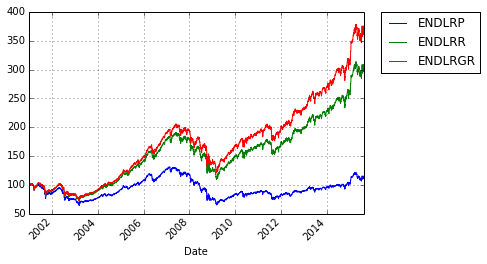

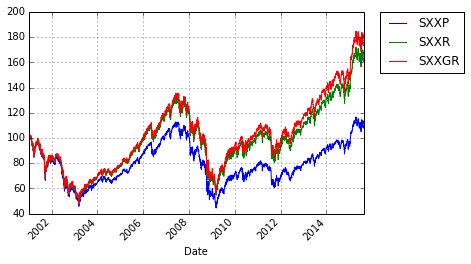

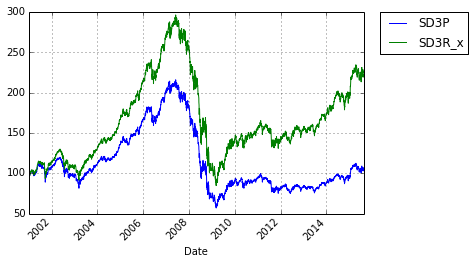

In [223]:
for df in [df1,df2,df3.iloc[:,:-1]]:
    df.iloc[:,1:] = (df.iloc[:,1:]/df.iloc[0,1:])*100
    df.index=df.Date
    del df['Date']
    df.plot()
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xticks(rotation=45)

In [ ]:
def get_exdt_table(identifier):
    ic = get_infocode(identifier)
    if np.isnan(ic):
        return pd.DataFrame(columns=['exdate'])
    else:        
        sql= """
        SELECT EffectiveDate FROM DS2Div
        WHERE InfoCode = '%s' AND NOT DivTypeCode='EXT'
        ORDER BY EffectiveDate DESC
        """ % (str(ic))
        res = pd.io.sql.read_sql(sql,con).values
        if len(res) > 0:
            df = pd.DataFrame(res, columns=['exdate']).fillna(0)
            return df
        else:
            return pd.DataFrame(columns=['exdate'])
        
dfagg = pd.read_csv(loc1 + '03_europe600_adtvEUR_dy.csv', sep=';').sort('dt',ascending=True)
#dfagg['dt'] = pd.to_datetime(dfagg['dt'], format='%Y-%m-%d', dayfirst=True)

#date table
dfdtt = dfagg.dt.drop_duplicates().reset_index(drop=True)
dfdtt[1:].reset_index(drop=True)
dfdt = pd.concat([dfdtt,dfdtt[1:].reset_index(drop=True),dfdtt[3:].reset_index(drop=True)], axis=1)
dfdt.columns = ['dfrom', 'dto1','dto2']
dfdt = dfdt.apply(lambda x: pd.to_datetime(x, format='%Y-%m-%d', dayfirst=True))

dfagg = dfagg.loc[:,dfagg.columns].reset_index(drop=True)
dfagg = dfagg.reset_index(drop=True)

ct = 0
dta = []
dfids = dfagg[['sedol','isin']].drop_duplicates().reset_index(drop=True)
for index, row in dfids.iterrows():
            
    if isnan(get_infocode(row.sedol)):
        df = get_exdt_table(dfids.loc[index,'isin']) 
        infocode = get_infocode(dfids.loc[index,'isin'])
    else:
        df = get_exdt_table(row.sedol)
        infocode = get_infocode(row.sedol)
        
    dfrow = dfagg[(dfagg.sedol==row.sedol) & (dfagg['isin']==dfids.loc[index,'isin'])].reset_index(drop=True)
    for s in range(len(dfrow)):
        
        deff=dt.datetime.strptime(dfrow.loc[s, 'dt'], '%Y-%m-%d')
        #dimp=deff-dt.timedelta(days=3) #implem date
                
        dfnext = dfdt[dfdt.dfrom==deff].iloc[0,1]
        dfnext2 = dfdt[dfdt.dfrom==deff].iloc[0,2]

        if len(df[(df.exdate<dfnext) & (df.exdate>=deff)])>0:
            #ct1m = len(df[(df.exdate<dfnext) & (df.exdate>=deff)])
            ct1m = True
            dts1m = df[(df.exdate<dfnext) & (df.exdate>=deff)].reset_index(drop=True).loc[0,'exdate']
        else:
            ct1m = False
            dts1m = ''
            
        #if len(df[(df.exdate<dfnext2) & (df.exdate>=deff)])>0:
        #    ct3m = len(df[(df.exdate<dfnext2) & (df.exdate>=deff)])
        #    dts3m = list(df[(df.exdate<dfnext2) & (df.exdate>=deff)]['exdate'])
        #else:
        #    ct3m = 0
        #    dts3m = 0            
        
        temp = np.array([dfrow.loc[s, 'dt'],
                         dfrow.loc[s, 'sedol'],
                         dfrow.loc[s,'isin'],
                         infocode,
                         ct1m,
                         dts1m])
        dta.append(temp)
            
        ct = ct+1
           
        if not (ct+1) % 1000:
            print(ct+1)
        
dfdta = pd.DataFrame(dta, columns=['dt','sedol','isin','infocode','ct1m','dts1m'])
dfres = pd.merge(dfagg, dfdta, how='left', on=['dt', 'sedol','isin']).drop_duplicates()

dfres.to_csv(loc1 + '03_europe600_adtvEUR_dy_exdt.csv',sep=';',index=False)
print('done')
dfres.head()

1000
2000
3000
4000
5000

In [229]:
df

,exdate


In [218]:
get_infocode('FR0000124711')

47657

In [209]:
dfdt

,dfrom,dto1,dto2
0,2001-11-19,2001-12-24,2002-02-18
1,2001-12-24,2002-01-21,2002-03-18
2,2002-01-21,2002-02-18,2002-04-22
3,2002-02-18,2002-03-18,2002-05-20
4,2002-03-18,2002-04-22,2002-06-24
5,2002-04-22,2002-05-20,2002-07-22
6,2002-05-20,2002-06-24,2002-08-19
7,2002-06-24,2002-07-22,2002-09-23
8,2002-07-22,2002-08-19,2002-10-21
9,2002-08-19,2002-09-23,2002-11-18


,dt,dt
0,2001-11-19,2001-12-24
1,2001-12-24,2002-04-22
2,2002-04-22,2002-12-23
3,2002-12-23,NaN


In [1]:
import sys
sys.path.append('G:/stoxx/STOXX/Product Development & Research/Python')
from stoxxqad import wspit
import pandas as pd


In [4]:
wspit.get_vencode('204625','2015-10-01',35)


6751

In [4]:
import sys
sys.path.append('G:/stoxx/STOXX/Product Development & Research/Python')
import pandas as pd
from stoxxwebsite import indexvalues as iv
from stoxxstats import fullstats as st
dfrom=dt.date(2000,1,1)
dto=dt.date(2015,10,2)
def filterdts(dfrom,dto,df):
    dfreturn=df[df['Date']>=dfrom][df['Date']<=dto]
    return dfreturn

df1 = iv.get_web_h(['SXXP', 'SXXR', 'SXXGR'], usedates=True, dfrom=dfrom, dto=dto) #Europe 600
df2 = iv.get_web_h(['ISEMVP', 'ISEMVT', 'ISEMVGT'], usedates=True, dfrom=dfrom, dto=dto, special=True) #iSTOXX Europe Min Var

st.calc_stats(df1, rfrate=True)
#st.calc_stats(df2, rfrate=True)

SXXP         SXXR       SXXGR  \
return actual         0  -0.07898012    0.3965352         NaN   
                      1    0.3496547    0.5601756   0.6067543   
                      2    0.2806863    0.3897103   0.4127256   
                      3   0.04761331   0.07523612  0.08078437   
                      4   0.01553103   0.03891238  0.04374208   
                      5  -0.01695586    -0.016049 -0.01584407   
return ann.           0 -0.005070742   0.02592248         NaN   
                      1   0.06011964   0.03034517  0.03660902   
                      2   0.08386415   0.02921188  0.03517929   
                      3   0.04647184   0.02693775  0.03234644   
                      4   0.02005892   0.03036497  0.03666199   
                      5   -0.1766159  0.008672869  0.01064422   
volatility ann.       0    0.1992029    0.1991728   0.2002563   
                      1    0.1650839    0.1650097   0.1649617   
                      2    0.1476871    0.1476953   0.1477134   
                      3    0.1975091    0.1976445   0.1976363   
                      4     0.201699    0.2018977    0.201926   
                      5    0.2659155    0.2656699   0.2656479   
dividend yield ann.   0          NaN   0.02592248         NaN   
                      1          NaN   0.03034517  0.03660902   
                      2          NaN   0.02921188  0.03517929   
                      3          NaN   0.02693775  0.03234644   
                      4          NaN   0.03036497  0.03666199   
                      5          NaN  0.008672869  0.01064422   
Sharpe ratio EUR ann. 0  -0.01034228    0.1189045         NaN   
                      1    0.4048658    0.5761917   0.6110863   
                      2    0.6185707    0.7986955   0.8349187   
                      3    0.2861171    0.4149582   0.4402298   
                      4    0.2264793    0.3719522   0.4018507   
                      5    -1.740163    -1.702989   -1.694376   
max drawdown          0    0.6104316    0.5868985           0   
                      1    0.2619522    0.2440804    0.240112   
                      2    0.1807226    0.1681411   0.1656006   
                      3    0.1807226    0.1681411   0.1656006   
                      4    0.1807226    0.1681411   0.1656006   
                      5   0.06746021    0.0667946  0.06671559   

                                   period  
return actual         0  as of 2000-01-03  
                      1                5y  
                      2                3y  
                      3                1y  
                      4               YTD  
                      5                1m  
return ann.           0  as of 2000-01-03  
                      1                5y  
                      2                3y  
                      3                1y  
                      4               YTD  
                      5                1m  
volatility ann.       0  as of 2000-01-03  
                      1                5y  
                      2                3y  
                      3                1y  
                      4               YTD  
                      5                1m  
dividend yield ann.   0  as of 2000-01-03  
                      1                5y  
                      2                3y  
                      3                1y  
                      4               YTD  
                      5                1m  
Sharpe ratio EUR ann. 0  as of 2000-01-03  
                      1                5y  
                      2                3y  
                      3                1y  
                      4               YTD  
                      5                1m  
max drawdown          0  as of 2000-01-03  
                      1                5y  
                      2                3y  
                      3                1y  
                      4               YTD  
                      5                1m

In [48]:
df2=get_web_h(['ISEMVP', 'ISEMVT', 'ISEMVGT'], usedates=True, dfrom=dfrom, dto=dto, special=True) #iSTOXX Europe Min Var


In [49]:
df2

,Date,ISEMVP,ISEMVT,ISEMVGT
0,2001-12-24,66.37,51.49,48.85
1,2001-12-27,67.32,52.22,49.55
2,2001-12-28,67.65,52.47,49.79
3,2001-12-31,67.67,52.49,49.80
4,2002-01-01,67.67,52.49,49.80
5,2002-01-02,66.78,51.85,49.21
6,2002-01-03,67.01,52.03,49.38
7,2002-01-04,67.19,52.18,49.51
8,2002-01-07,66.75,51.83,49.19
9,2002-01-08,66.41,51.57,48.94


In [27]:
pd.DataFrame(data)

,0
0,Date
1,24.12.2001
2,27.12.2001
3,28.12.2001
4,31.12.2001
5,01.01.2002
6,02.01.2002
7,03.01.2002
8,04.01.2002
9,07.01.2002


In [4]:
import sys
sys.path.append('G:/stoxx/STOXX/Product Development & Research/Python')
from stoxx.website import indexvalues as ix
from stoxx.stats import fullstats as sts

sts.calc_stats(ix.get_web_h(['ISXMJQYP','ISXMJQYN','ISXMJQYG'], usedates=False))

ISXMJQYP      ISXMJQYN     ISXMJQYG  \
return actual         0      0.6311        0.9897         1.02   
                      1    1.074399      1.238385     1.264828   
                      2    1.046036      1.124159     1.139831   
                      3   0.2386847     0.2517773    0.2551261   
                      4  0.09293755     0.1042233     0.107092   
                      5  0.08127279    0.08129993   0.08131256   
return ann.           0  0.03319973     0.0469978   0.04805467   
                      1   0.1501484      0.167048    0.1696787   
                      2   0.2575466     0.2727215    0.2757196   
                      3   0.2285288     0.2410121    0.2442043   
                      4   0.1099405     0.1234048     0.126831   
                      5    1.655773      1.656606     1.656994   
volatility ann.       0   0.2093314     0.2093399    0.2093482   
                      1   0.1847955      0.184744      0.18479   
                      2    0.195523     0.1956055     0.195674   
                      3   0.2055848     0.2053505    0.2053356   
                      4   0.2076811     0.2074295    0.2074105   
                      5   0.2667671     0.2666107    0.2666277   
dividend yield ann.   0         NaN    0.01379806   0.01485494   
                      1         NaN    0.01689953   0.01953022   
                      2         NaN    0.01517485     0.018173   
                      3         NaN    0.01248329   0.01567548   
                      4         NaN    0.01346431   0.01689053   
                      5         NaN  0.0008334263  0.001221459   
Sharpe ratio EUR ann. 0   0.1807433     0.2441158    0.2489328   
                      1   0.8353069      0.914419    0.9265528   
                      2    1.267167      1.327916     1.339753   
                      3    1.126505      1.177088       1.1898   
                      4   0.6116371     0.6704232    0.6851911   
                      5    7.840321      7.844101     7.844622   
max drawdown          0   0.6157782     0.6075769    0.6075447   
                      1   0.2174962     0.2025586    0.2009079   
                      2   0.1960697     0.1922601    0.1914278   
                      3   0.1960697     0.1922601    0.1914278   
                      4   0.1960697     0.1922601    0.1914278   
                      5  0.02752585    0.02750481   0.02745198   

                                   period  
return actual         0  as of 2001-06-18  
                      1                5y  
                      2                3y  
                      3                1y  
                      4               YTD  
                      5                1m  
return ann.           0  as of 2001-06-18  
                      1                5y  
                      2                3y  
                      3                1y  
                      4               YTD  
                      5                1m  
volatility ann.       0  as of 2001-06-18  
                      1                5y  
                      2                3y  
                      3                1y  
                      4               YTD  
                      5                1m  
dividend yield ann.   0  as of 2001-06-18  
                      1                5y  
                      2                3y  
                      3                1y  
                      4               YTD  
                      5                1m  
Sharpe ratio EUR ann. 0  as of 2001-06-18  
                      1                5y  
                      2                3y  
                      3                1y  
                      4               YTD  
                      5                1m  
max drawdown          0  as of 2001-06-18  
                      1                5y  
                      2                3y  
                      3                1y  
                      4               YTD  


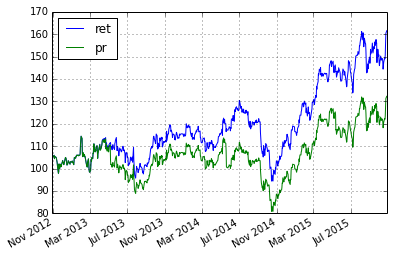

In [20]:
a=get_timeseries_total_return3('DE000A1J5RX9', 'B7VG6L8', dt.date(2005,10,1), dt.date(2015,10,30), 'EUR')
b=get_timeseries_adj_close3('DE000A1J5RX9', 'B7VG6L8', dt.date(2005,10,1), dt.date(2015,10,30), 'EUR')
c=pd.concat([a,b],axis=1)
c =c.fillna(method='pad')
c.columns=['ret','pr']
c=c/c.iloc[0,:]*100
c.plot()

In [73]:
#adtv calc comparison with ENG
import pandas as pd
import numpy as np
import datetime as dt
import qadconnect34 as q 
import myfunctions as myf
import pyodbc

creds = 'DRIVER={SQL Server};SERVER=mpzhwindex01;DATABASE=qai;UID=stx-ro;PWD=stx-ro'
con = pyodbc.connect(creds)

loc='G:/stoxx/STOXX/Product Development & Research/Projects/1881 OSSIAM Min Var High Div/04 Data/'
loc1= loc+'01_selection_steps/'

dfagg = pd.read_csv(loc1 + '01_europe600_data_info.csv', sep=';').sort('dt',ascending=True)
#dfagg = dfagg[(dfagg.dt=='2015-10-19') & (dfagg.sedol=='BXDZ9Q1')]

dat = dfagg.dt.drop_duplicates()
for da in dat:
    dft = dfagg[dfagg.dt==da].reset_index(drop=True)
    dft = dft.loc[0,:]
    dft = pd.DataFrame(dft).T
    
    for index, row in dft.iloc[:,:].iterrows():

        if not np.isnan(row.infocode):
            ic = int(row.infocode)
        else:
            ic = 0

        dto=dt.datetime.strptime(row['dt-cut'], '%Y-%m-%d')# - dt.timedelta(days=6)
        dfrom=dt.datetime.strptime(row['dt-50'], '%Y-%m-%d')# - dt.timedelta(days=6) 

        curr='EUR'

        dfprim = q.get_adtv_prim_plus(str(row['sedol']), dto, dfrom, curr, ic)
        #dfprim = dfprim.loc[1:,:]
        
        len1 = len(dfprim)
        dfprim = dfprim[-dfprim.volume.isnull()].reset_index(drop=True)  
        len2 = len(dfprim)
        print(len1, len2)
        
        if len(dfprim)>=45: #max missing data is 10%
            adtv_prim=np.mean(dfprim.loc[:,'close_'] * dfprim.loc[:,'volume'])   
        else:
            adtv_prim=0

        print(dto, dfrom, '-', row.sedol, '-', row.infocode, '-', adtv_prim)
    
dfprim


50 50
2001-11-13 00:00:00 2001-09-05 00:00:00 - 4532673 - 39393.0 - 5256543.41167
50 50
2001-12-18 00:00:00 2001-10-10 00:00:00 - 4532673 - 39393.0 - 6921411.31397
48 48
2002-01-15 00:00:00 2001-11-02 00:00:00 - 4532673 - 39393.0 - 6794616.71726
48 48
2002-02-12 00:00:00 2001-11-30 00:00:00 - 4532673 - 39393.0 - 5574919.77167
50 50
2002-03-12 00:00:00 2002-01-02 00:00:00 - 4532673 - 39393.0 - 4745523.29886
50 50
2002-04-16 00:00:00 2002-02-04 00:00:00 - 4532673 - 39393.0 - 5174997.50564
49 49
2002-05-14 00:00:00 2002-03-04 00:00:00 - 4532673 - 39393.0 - 7157826.94579
49 49
2002-06-18 00:00:00 2002-04-10 00:00:00 - 4532673 - 39393.0 - 8181650.05945
50 50
2002-07-16 00:00:00 2002-05-08 00:00:00 - 4532673 - 39393.0 - 6169756.78832
50 50
2002-08-13 00:00:00 2002-06-05 00:00:00 - 4532673 - 39393.0 - 5022598.51967
50 50
2002-09-17 00:00:00 2002-07-10 00:00:00 - 4532673 - 39393.0 - 6087215.7722
50 50
2002-10-15 00:00:00 2002-08-07 00:00:00 - 4532673 - 39393.0 - 5559554.56187
50 50
2002-11-12 

,marketdate,close_,volume,exch
0,2015-10-07,13.143981,3236181,188
1,2015-10-08,13.306397,2928281,188
2,2015-10-09,13.404135,2813257,188
3,2015-10-12,13.408002,2388439,188
4,2015-10-13,13.242099,2207275,188
5,2015-10-14,13.023157,4406692,188
6,2015-10-15,13.029352,2641015,188
7,2015-10-16,13.160148,2950011,188
8,2015-10-19,13.135592,2284160,188
9,2015-10-20,13.274901,3078480,188


In [88]:
dto = dt.date(2003,4,17)
dfrom = dt.date(2003,2,5)
q.get_adtv_prim_plus(str(757416), dto, dfrom, 'EUR', 3236)

dto = dt.date(2004,5,18)
dfrom = dt.date(2004,3,5)
dfprim = q.get_adtv_prim_plus(str(757416), dto, dfrom, 'EUR', 42365)
print(np.mean(dfprim.loc[:,'close_'] * dfprim.loc[:,'volume']))
dfprim

66725468.8923


,marketdate,close_,volume,exch
0,2004-03-05,24.827137,78484500,188
1,2004-03-08,25.279827,16464234,188
2,2004-03-09,24.954950,1139220,188
3,2004-03-10,24.875216,889294,188
4,2004-03-11,24.225964,1431455,188
5,2004-03-12,24.232285,1054143,188
6,2004-03-15,24.081392,1483198,188
7,2004-03-16,24.233246,642949,188
8,2004-03-17,24.331692,223418,188
9,2004-03-18,23.844205,394443,188


In [72]:
for index, row in dfagg[['dt','dt-cut']].drop_duplicates().iterrows():
    d = row['dt-cut']
    if dt.date(int(d[:4]), int(d[5:7]), int(d[8:10])).weekday()!=1:
        print(d, row['dt'])

In [35]:
'2003-04-14'
'2008-03-17'
'2014-04-14'

datetime.date(2015, 12, 15)

In [109]:
dto=dt.datetime.strptime('2014-04-16', '%Y-%m-%d')
dtadjust = dto.weekday()-1
dto=dto-dt.timedelta(days=dtadjust)
dto

datetime.datetime(2014, 4, 15, 0, 0)

In [99]:
### 2087 methodology change
import sys
import datetime as dt
sys.path.append('G:/stoxx/STOXX/Product Development & Research/Python')
from stoxx.launch import upload_4d as u4d

fld = 'G:/stoxx/STOXX/Product Development & Research/Projects/2087 iSTOXX Europe Min Var - methodology change/'
dff = get_web_file('https://www.stoxx.com/document/Indices/Current/Composition_Files/opening_minimum_variance.txt')
dff.columns = dff.iloc[4,:].tolist()
dat = dff.iloc[1,0][-10:]
dff = dff.iloc[5:,:37]
dff['dt'] = dat
dfmv = dff[dff['Index ISIN']=='CH0128395313'][[37,5,6,11,14,26,27,28,29,35]].reset_index(drop=True)
dfmv['Weight'] = dfmv['Weight'].map(lambda x: float(x[:-1])/100)
dfmv = dfmv.rename(columns={'Weight':'weight'})

indexsymbol = 'ISEMVP'
cutdt = '20160303'

dfp = get_prod_close_EUR(cutdt)[[1,3,15,17,21]]

df = pd.merge(dfmv, dfp, how='left', on='ISIN')
df = df[[10,9]] #symbol and weight

dfwf = u4d.get_4d_wf_file(df, cutdt, indexsymbol, 'internal_key')
dfwf.to_csv(fld + 'isemvp_4d_weightfactor_'+ str(dt.date.today()).replace('-','') +'.csv' ,sep=';',index=False)

dfcomp = u4d.get_4d_comp_file(df, cutdt, indexsymbol, 'internal_key')
dfcomp.to_csv(fld + 'isemvp_4d_composition_'+ str(dt.date.today()).replace('-','') +'.csv' ,sep=';',index=False)

In [ ]:
#4D
import sys
sys.path.append('G:/stoxx/STOXX/Product Development & Research/Python')
from stoxx.launch import upload_4d as u4d

df4d = pd.read_csv(loc1 + '06_europe600_mvhd_selection_map_wgt.csv',sep=';')
df4d = df4d[(df4d.dt=='2016-02-22') & -(df4d.weight.isnull())].reset_index(drop=True)

indexsymbol = 'ISEMVHDP'
cutdt = '20160216' #pricing cut of to calculate weightfactors

dfwf = u4d.get_4d_wf_file(df4d, cutdt, indexsymbol, 'symbol')
dfwf.to_csv(loc2 + 'isemvhdp_4d_weightfactor_'+ str(dt.date.today()).replace('-','') +'.csv' ,sep=';',index=False)

dfcomp = u4d.get_4d_comp_file(df4d, cutdt, indexsymbol, 'symbol')
dfcomp.to_csv(loc2 + 'isemvhdp_4d_composition_'+ str(dt.date.today()).replace('-','') +'.csv' ,sep=';',index=False)

print('done')

In [29]:
x = get_adtv_sec_plus('DE000TUAG000', '2016-03-01', '2015-12-01', 'EUR')
y = get_adtv_prim_plus('DE000TUAG000', '2016-03-01', '2015-12-01', 'EUR')
#x[x.Exch==59] #59 104
y


,marketdate,close_,volume,exch
0,2015-12-01,16.140000,899845,78
1,2015-12-02,16.330002,531981,78
2,2015-12-03,15.630001,1160481,78
3,2015-12-04,15.790000,536663,78
4,2015-12-07,16.130005,503510,78
5,2015-12-08,15.570000,642110,78
6,2015-12-09,15.545001,662847,78
7,2015-12-10,16.250000,1882958,78
8,2015-12-11,15.985000,1036505,78
9,2015-12-14,15.950000,697912,78


In [27]:
np.unique(list(x.exch))

array([233, 234, 238, 239, 285, 289, 290, 292, 293], dtype=int64)

In [18]:
get_adtv_prim_plus('ES0177542018', '2016-03-01', '2015-12-01', 'EUR')

,marketdate,close_,volume,exch
0,2015-12-01,8.181947,8063996,104
1,2015-12-02,8.289749,6374852,104
2,2015-12-03,7.968404,10383590,104
3,2015-12-04,8.100985,8293805,104
4,2015-12-07,8.152209,6530555,104
5,2015-12-08,8.042729,8332406,104
6,2015-12-09,7.966501,8068383,104
7,2015-12-10,7.943987,7369859,104
8,2015-12-11,7.837573,5329211,104
9,2015-12-14,7.754008,6933977,104


In [1]:
Adjusted_Close_EUR_Priceindex

In [8]:
#methodology change - 2087
import pandas as pd
import numpy as np
import sys
import datetime as dt
import myfunctions as myf
sys.path.append('G:/stoxx/STOXX/Product Development & Research/Python')
from stoxx.launch import upload_4d as up4

locmc = 'G:/stoxx/STOXX/Product Development & Research/Projects/2087 iSTOXX Europe Min Var - methodology change/Launch/'
#https://www.stoxx.com/document/Indices/Current/Composition_Files/opening_minimum_variance.txt
df = myf.get_web_file('https://www.stoxx.com/document/Indices/Current/Composition_Files/opening_minimum_variance.txt')
df.columns = df.iloc[4,:]
df= df.iloc[5:,:]
df = df[df['Index ISIN']=='CH0124001618'].reset_index(drop=True)
df= df[[1,4,5,6,11,14,27,29,31,34,35]]

#pricing file
dt1 = '20160707' 

stx = pd.read_excel('M:/Production/FinalSheets/s6/archive/stoxx_components_global_'+ dt1 +'.xls')
stx = stx[['Sedol', 'Internal_Key', 'Adjusted_Close_EUR_Priceindex']]
stx.columns = ['Sedol', 'Symbol', 'pr']
df = pd.merge(df, stx, on='Sedol', how='left')
df['Market Cap. (in Mio. index currency)'] = df['Market Cap. (in Mio. index currency)'].map(lambda x: float(x.replace("'",'')))
df['wgt'] = df['Market Cap. (in Mio. index currency)'] / df['Market Cap. (in Mio. index currency)'].sum()
df['weightfactor'] = 100000000000*df['wgt'] / df['pr']
df['weightfactor'] = df['weightfactor'].map(lambda x: np.around(x, decimals=0))

df = df[['Symbol', 'weightfactor']]

def get_4d_wf_fields(df, indexsymbol):
    yesterday = str(dt.date.today()-dt.timedelta(days=1)).replace('-','')
    df['valid_from'] = yesterday
    df['valid_to'] = 99991231
    df['index_symbol'] = indexsymbol
    df['size'] = 'Y'
    df['description'] = np.nan
    df['not_rep_before'] = yesterday
    df['capfactor'] = 1
    return df

df = get_4d_wf_fields(df, 'ISEMVP')
df = df.rename(columns={'Symbol':'dj_id'})

#df.to_csv(locmc + 'all.csv', sep=';')
df[['valid_from', 'valid_to', 'index_symbol', 'dj_id', 'size', 'description', 'not_rep_before']].to_csv(locmc + 'isemvp_compostion_'  + str(dt.date.today()) + '.csv', sep=';', index=False)
df[['valid_from', 'valid_to', 'index_symbol', 'dj_id', 'weightfactor', 'capfactor', 'description', 'not_rep_before']].to_csv(locmc + 'isemvp_factors_'  + str(dt.date.today()) + '.csv', sep=';', index=False)
df.head()

,dj_id,weightfactor,valid_from,valid_to,index_symbol,size,description,not_rep_before,capfactor
0,408580,24907498,20160707,99991231,ISEMVP,Y,NaN,20160707,1
1,406566,43191682,20160707,99991231,ISEMVP,Y,NaN,20160707,1
2,595425,5302949,20160707,99991231,ISEMVP,Y,NaN,20160707,1
3,403197,12029816,20160707,99991231,ISEMVP,Y,NaN,20160707,1
4,400169,34966517,20160707,99991231,ISEMVP,Y,NaN,20160707,1


In [11]:
from stoxx.launch import history_divisors as hd
loc_h = 'G:/stoxx/STOXX/Product Development & Research/Projects/2087 iSTOXX Europe Min Var - methodology change/Launch/'
df = get_web_h(['ISEMVP', 'ISEMVT', 'ISEMVGT'], usedates=True, special=True).tail(1)

hd.get_divisor_output(df, loc_h)

In [12]:
loc_h = 'G:/stoxx/STOXX/Product Development & Research/Projects/2087 iSTOXX Europe Min Var - methodology change/Launch/'

,Date,ISEMVP,ISEMVT,ISEMVGT
3735,2016-07-08,136.27,157.89,163.04


In [21]:
#final files
loc_h = 'G:/stoxx/STOXX/Product Development & Research/Projects/2087 iSTOXX Europe Min Var - methodology change/Launch/'
loc_f = loc_h + 'implementations/'
dfi = pd.read_excel(loc_f + 'MIN_VAR.xls', sheetname='FORECAST')
dfi = dfi[['SYMBOL_', 'weightfactor']]

def get_4d_wf_fields(df, indexsymbol):
    #yesterday = str(dt.date.today()-dt.timedelta(days=1)).replace('-','')
    yesterday = 20160718
    df['valid_from'] = yesterday
    df['valid_to'] = 99991231
    df['index_symbol'] = indexsymbol
    df['size'] = 'Y'
    df['description'] = np.nan
    df['not_rep_before'] = yesterday
    df['capfactor'] = 1
    return df

df = get_4d_wf_fields(dfi, 'ISEMVP')
df = df.rename(columns={'SYMBOL_':'dj_id'})

df.to_csv(loc_f + 'all.csv', sep=';')
df[['valid_from', 'valid_to', 'index_symbol', 'dj_id', 'size', 'description', 'not_rep_before']].to_csv(loc_f + 'isemvp_compostion_'  + str(dt.date.today()) + '.csv', sep=';', index=False)
df[['valid_from', 'valid_to', 'index_symbol', 'dj_id', 'weightfactor', 'capfactor', 'description', 'not_rep_before']].to_csv(loc_f + 'isemvp_factors_'  + str(dt.date.today()) + '.csv', sep=';', index=False)
df.head()


,dj_id,weightfactor,valid_from,valid_to,index_symbol,size,description,not_rep_before,capfactor
0,755257,215708,20160718,99991231,ISEMVP,Y,NaN,20160718,1
1,B119QG,4275242,20160718,99991231,ISEMVP,Y,NaN,20160718,1
2,B01C3S,41452841,20160718,99991231,ISEMVP,Y,NaN,20160718,1
3,028758,7061124,20160718,99991231,ISEMVP,Y,NaN,20160718,1
4,048354,79098883,20160718,99991231,ISEMVP,Y,NaN,20160718,1
